In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt 
import pytz   
import math
import geopandas as gpd
from shapely.geometry import Point,Polygon
from fiona.crs import from_epsg

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

from libpysal.weights import Queen, lag_spatial
from esda.moran import Moran
import spreg

from statsmodels.tsa.arima.model import ARIMA
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

from sklearn import datasets
from sklearn import manifold

from sklearn.decomposition import PCA, TruncatedSVD, FactorAnalysis, FastICA 
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, f_regression
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, mean_squared_error
import pickle
from joblib import dump, load

import umap
import shap

C:\Users\yansh\anaconda3\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Load data

In [2]:
gc = gpd.read_file('data/geo_res/filtered_counties_full.shp') # list of county

In [3]:
cnt_lst = pd.read_csv('data/list of county.txt', header=None) # list of county names

In [171]:
cnt_lst.head(19)

,0,1,2,3,4
0,CA,6,1,Alameda County,H1
1,CA,6,3,Alpine County,H1
2,CA,6,5,Amador County,H1
3,CA,6,7,Butte County,H1
4,CA,6,9,Calaveras County,H1
5,CA,6,11,Colusa County,H1
6,CA,6,13,Contra Costa County,H1
7,CA,6,15,Del Norte County,H1
8,CA,6,17,El Dorado County,H1
9,CA,6,19,Fresno County,H1


In [5]:
gc.head()

,COUNTYFP,ALAND,AWATER,geometry
0,001,1909616630,216916717,"POLYGON ((-165115.207 -57810.620, -165115.682 ..."
1,003,1912292631,12557304,"POLYGON ((-6370.701 76117.959, -6362.443 76124..."
2,005,1539933576,29470568,"POLYGON ((-55089.030 36242.607, -55092.537 362..."
3,007,4238438196,105310997,"POLYGON ((-164416.520 145416.919, -164413.304 ..."
4,009,2641829199,43797662,"POLYGON ((-32925.913 14059.645, -32924.579 140..."


In [4]:
# time*county*attributes
atts = np.load('data/inputs_final.npy')#np.load('data/inputs_filled.npy') # days*counties*attributes
cases = np.load('data/labels.npy') # days*counties*1

In [219]:
###### merge and normalize data ######
data = np.concatenate([atts, np.expand_dims(cases, axis=2)], axis=2)
print(data.shape)
scalers = []
for i in range(data.shape[2]): # normalize by attributes
    sclr = MinMaxScaler()
    sclr.fit(data[:, :, i])
    data[:, :, i] = sclr.transform(data[:, :, i])
    scalers.append(sclr)

(121, 58, 87)


In [220]:
data = data[60:]
data.shape

(61, 58, 87)

In [7]:
eps = 1e-7
gc_by_day = [] # list of dataframes, graph with attributes per day
cols = ['lc_e_count', 'lc_e_mean', 'lc_e_std', 'lc_e_min', 'lc_e_25', 'lc_e_50', 'lc_e_75', 'lc_e_max', 
       'lc_n_count', 'lc_n_mean', 'lc_n_std', 'lc_n_min', 'lc_n_25', 'lc_n_50', 'lc_n_75', 'lc_n_max', 
       'lc_s_count', 'lc_s_mean', 'lc_s_std', 'lc_s_min', 'lc_s_25', 'lc_s_50', 'lc_s_75', 'lc_s_max', 
       'lc_w_count', 'lc_w_mean', 'lc_w_std', 'lc_w_min', 'lc_w_25', 'lc_w_50', 'lc_w_75', 'lc_w_max', 
       'lc_u_count', 'lc_u_mean', 'lc_u_std', 'lc_u_min', 'lc_u_25', 'lc_u_50', 'lc_u_75', 'lc_u_max',
       'ic_e_count', 'ic_e_mean', 'ic_e_std', 'ic_e_min', 'ic_e_25', 'ic_e_50', 'ic_e_75', 'ic_e_max', 
       'ic_n_count', 'ic_n_mean', 'ic_n_std', 'ic_n_min', 'ic_n_25', 'ic_n_50', 'ic_n_75', 'ic_n_max', 
       'ic_s_count', 'ic_s_mean', 'ic_s_std', 'ic_s_min', 'ic_s_25', 'ic_s_50', 'ic_s_75', 'ic_s_max', 
       'ic_w_count', 'ic_w_mean', 'ic_w_std', 'ic_w_min', 'ic_w_25', 'ic_w_50', 'ic_w_75', 'ic_w_max', 
       'ic_u_count', 'ic_u_mean', 'ic_u_std', 'ic_u_min', 'ic_u_25', 'ic_u_50', 'ic_u_75', 'ic_u_max',
       'retail_n_recreation', 'grocery_n_pharmacy', 'parks', 'transit_stations', 'workplaces', 'residential', 'case']
for i in range(data.shape[0]):
    _gc = gc.copy()
    _gc['name'] = cnt_lst[3]
    for j, c in enumerate(cols):
        _gc[c] = data[i, :, j]
    _gc['case'] = _gc['case'] + eps # avoid devided by 0
    gc_by_day.append(_gc)

# Dimension reduction

In [8]:
dr_data = data[:, :, :-1].reshape((data.shape[0]*data.shape[1], data.shape[2]-1))
dr_label = data[:, :, -1].reshape((data.shape[0]*data.shape[1]))
print(dr_data.shape, dr_label.shape)

(3538, 86) (3538,)


In [12]:
# PCA: all singular values are around 0.01
# T-SNE: can only keep <4 components
# LLE, ISOMAP, MDS: performance cannot be measured, more about classification
pca = PCA(n_components=86) # keep 10 features
pca.fit(dr_data)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.17407665 0.08107829 0.06373435 0.05590242 0.03636739 0.03383616
 0.02782611 0.0228794  0.01836369 0.01700092 0.01674161 0.0157004
 0.01334464 0.01153759 0.01061316 0.01013622 0.00966201 0.00943863
 0.00924139 0.00912342 0.00879204 0.00850288 0.00827393 0.0080792
 0.00791496 0.00789958 0.00777377 0.00768889 0.00753263 0.00738603
 0.00727858 0.00713998 0.0070317  0.00695309 0.00682276 0.00671912
 0.00661081 0.00656205 0.00649606 0.00641854 0.00631945 0.00625419
 0.00612623 0.00608588 0.006016   0.00595603 0.00592424 0.00570348
 0.00564899 0.00561521 0.00553976 0.00545878 0.00539198 0.00531807
 0.00522593 0.00513517 0.00509068 0.00492104 0.00485796 0.00482939
 0.00478133 0.00468988 0.00468157 0.00443309 0.00430389 0.00417859
 0.00413699 0.00406847 0.0039025  0.00382105 0.00375939 0.00367351
 0.00360257 0.00356466 0.00343265 0.00337218 0.003318   0.00326105
 0.00319306 0.00311914 0.00308703 0.00298713 0.00281132 0.00273509
 0.00267472 0.00251163]
[62.4916668  42.64853617 37.81278118 35.

In [14]:
for i in range(len(pca.explained_variance_ratio_)):
    print(i, sum(pca.explained_variance_ratio_[:i+1]))

0 0.1740766529355523
1 0.25515494090518487
2 0.31888928981643816
3 0.3747917131943037
4 0.4111591069615227
5 0.4449952711068093
6 0.47282138335337814
7 0.49570077980768845
8 0.5140644696300615
9 0.531065391648328
10 0.547807003866314
11 0.5635074059802402
12 0.5768520435562049
13 0.5883896324744505
14 0.5990027934790136
15 0.6091390178675619
16 0.6188010253737197
17 0.6282396514983363
18 0.637481045590313
19 0.646604462381614
20 0.6553965022904902
21 0.663899382438468
22 0.67217331111038
23 0.6802525094580798
24 0.6881674651277311
25 0.6960670460189343
26 0.7038408196197908
27 0.7115297052809391
28 0.7190623310630284
29 0.7264483589714451
30 0.7337269412071481
31 0.7408669204932968
32 0.7478986203119355
33 0.7548517119758978
34 0.7616744732030895
35 0.7683935941523172
36 0.7750044048252364
37 0.7815664547287411
38 0.7880625135798656
39 0.7944810556719699
40 0.8008005099120722
41 0.8070547031492131
42 0.8131809284079691
43 0.8192668051193193
44 0.8252828082168013
45 0.8312388389894778
4

In [15]:
print(dr_data.shape)
print(np.sort(dr_data.var(axis=1))) # low variation filter
print(np.sort(np.abs(np.corrcoef(dr_data.T)), axis=1)) # high correlation filter (remove if abs(corr)>0.5)

(3538, 86)
[0.00528515 0.00978906 0.01115966 ... 0.19364476 0.19997651 0.20522307]
[[1.66763644e-04 7.71545659e-03 1.03201897e-02 ... 3.85621699e-01
  4.32950687e-01 1.00000000e+00]
 [3.74070208e-03 3.97313807e-03 1.01853711e-02 ... 4.94276974e-01
  5.04098980e-01 1.00000000e+00]
 [2.83618962e-03 3.18134309e-03 4.46284161e-03 ... 4.28231603e-01
  4.51611056e-01 1.00000000e+00]
 ...
 [4.58366478e-04 7.26067606e-04 1.38422921e-03 ... 3.26559429e-01
  4.30132497e-01 1.00000000e+00]
 [1.94628798e-03 3.65751645e-03 7.33759000e-03 ... 1.64553590e-01
  4.51014879e-01 1.00000000e+00]
 [7.93205751e-03 2.57201545e-02 2.84094985e-02 ... 3.87487043e-01
  4.51014879e-01 1.00000000e+00]]


In [9]:
# random forest supervised regeression
rf = RandomForestRegressor(random_state=1, max_depth=10)
rf.fit(dr_data, dr_label)
np.sort(rf.feature_importances_)

array([0.000997  , 0.00108324, 0.00131657, 0.00133517, 0.00135366,
       0.00138238, 0.00145656, 0.00163554, 0.00169229, 0.00171112,
       0.00181077, 0.00185736, 0.001866  , 0.00189819, 0.00189848,
       0.00203671, 0.00205228, 0.00206191, 0.00206682, 0.00209565,
       0.00211713, 0.00212953, 0.0021903 , 0.00224336, 0.00226924,
       0.0023796 , 0.00239193, 0.00240878, 0.00271451, 0.00275665,
       0.0028661 , 0.00287772, 0.00298696, 0.0030259 , 0.00314394,
       0.0031743 , 0.00321022, 0.0032922 , 0.00347932, 0.00353793,
       0.00359174, 0.00364686, 0.00366821, 0.00373726, 0.00378189,
       0.00388773, 0.00402571, 0.00406739, 0.00412523, 0.00439032,
       0.0044676 , 0.00447926, 0.00471828, 0.00491376, 0.00512297,
       0.00539502, 0.00542587, 0.00562234, 0.00594865, 0.00596042,
       0.00636324, 0.00672857, 0.00716319, 0.00784834, 0.00806548,
       0.00843604, 0.00850919, 0.0085872 , 0.00911886, 0.0092403 ,
       0.00930052, 0.01013707, 0.01120091, 0.01130055, 0.01292

In [10]:
ta = np.sort(rf.feature_importances_)[::-1]
for i in range(ta.shape[0]):
    print(i, ta[:i+1].sum())

0 0.21578279903409608
1 0.3443787781875506
2 0.44336327376183116
3 0.5178892244436247
4 0.5746919090893583
5 0.6037781498112091
6 0.6231038372508999
7 0.6420066377053876
8 0.6575505520279212
9 0.6720859906418144
10 0.6852964003300163
11 0.6982207290262388
12 0.7095212792022392
13 0.7207221863528064
14 0.7308592545063121
15 0.7401597712090767
16 0.7494000725821304
17 0.7585189288646181
18 0.7671061280736062
19 0.7756153171632704
20 0.7840513538711933
21 0.7921168311550251
22 0.7999651747452324
23 0.8071283620472471
24 0.8138569316914911
25 0.8202201682872127
26 0.8261805835543345
27 0.8321292376404199
28 0.8377515774247902
29 0.8431774456173827
30 0.848572465938947
31 0.8536954316309874
32 0.858609188095318
33 0.8633274688577376
34 0.8678067316873147
35 0.8722743334055965
36 0.8766646576700688
37 0.8807898844919827
38 0.8848572741250481
39 0.8888829841014985
40 0.8927707113336896
41 0.8965526001896339
42 0.9002898627040349
43 0.9039580715402001
44 0.9076049356721612
45 0.911196675574831

In [22]:
# Backward Feature Elimination
lreg = LinearRegression()
rfe = RFE(lreg)
rfe_res = rfe.fit_transform(dr_data, dr_label)
rfe.ranking_ # rank of attributes

array([ 1, 23,  1,  1,  2,  1,  1, 39, 43,  1,  1,  1, 17, 44, 20, 32, 27,
        5, 31,  4, 37, 16, 30,  1, 38, 18, 36,  1,  1,  3,  1,  9,  1,  1,
       41,  6, 29,  8,  1,  1,  1, 24,  1,  1,  1, 25, 11,  1,  7, 14,  1,
       10, 13,  1, 22, 19,  1,  1,  1, 40,  1, 26, 12,  1, 33,  1,  1, 42,
        1,  1,  1, 34,  1,  1, 21,  1,  1, 28,  1, 15,  1,  1,  1, 35,  1,
        1])

In [23]:
(rfe.ranking_==1).sum() # 43 important attributes

43

In [24]:
np.where(rfe.ranking_==1)

(array([ 0,  2,  3,  5,  6,  9, 10, 11, 23, 27, 28, 30, 32, 33, 38, 39, 40,
        42, 43, 44, 47, 50, 53, 56, 57, 58, 60, 63, 65, 66, 68, 69, 70, 72,
        73, 75, 76, 78, 80, 81, 82, 84, 85], dtype=int64),)

In [25]:
# Forward Feature Selection
ffs = f_regression(dr_data, dr_label)

In [26]:
np.argsort(ffs[0][ffs[0]>0.5])

array([ 8,  3, 79, 16, 34, 10, 35,  0, 37, 36, 78,  5, 73, 40,  2, 38, 76,
       77, 20, 72, 15, 75, 13, 11, 14, 32, 64, 18,  9, 74, 12, 24, 33, 17,
       59, 27,  7, 67,  1, 21, 39, 68, 19, 22, 51, 84, 56, 43, 48,  4, 44,
       26, 31,  6, 50, 42, 55, 23, 47, 52, 60, 41, 25, 45, 28, 30, 61, 29,
       63, 83, 58, 46, 62, 66, 71, 53, 82, 54, 65, 69, 49, 70, 57, 81, 80],
      dtype=int64)

In [102]:
# factor analysis used to explore multicollinearity (can be evaluated by variance inflation factor (VIF))
fa = FactorAnalysis(n_components = 10).fit_transform(dr_data)

In [105]:
# independent component analysis
ica = FastICA(n_components=10, random_state=12) 
X=ica.fit_transform(dr_data)

In [ ]:
plt.figure(figsize=(12,8))
for i in range(X.shape[1]-1):
    plt.scatter(X[:,i], X[:,i+1])

Dimension reduction by Random Forest Regressor

In [11]:
pos_dr = np.argsort(rf.feature_importances_)[::-1][:43]
tmp = dr_data[:, pos_dr]

In [12]:
tmp = tmp.reshape((data.shape[0], data.shape[1], -1))
tmp.shape

(61, 58, 43)

In [13]:
gc_by_day_tmp = [] # list of dataframes, graph with attributes per day
cols_tmp = []
for i in pos_dr:
    cols_tmp.append(cols[i])
cols_tmp.append('case')
for i in range(data.shape[0]):
    _gc = gc.copy()
    _gc['name'] = cnt_lst[3]
    for j, c in enumerate(cols_tmp):
        _gc[c] = data[i, :, j]
    _gc['case'] = _gc['case'] + eps # avoid devided by 0
    gc_by_day_tmp.append(_gc)

In [14]:
gc_dr = pd.concat(gc_by_day_tmp)
gc_dr.head()

,COUNTYFP,ALAND,AWATER,geometry,name,grocery_n_pharmacy,retail_n_recreation,workplaces,parks,residential,...,ic_e_count,lc_w_min,ic_e_max,ic_e_std,ic_w_min,lc_s_std,ic_e_mean,ic_u_max,ic_e_50,case
0,001,1909616630,216916717,"POLYGON ((-165115.207 -57810.620, -165115.682 ...",Alameda County,0.750000,0.315032,0.298730,0.432413,0.293627,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.733333,0.406624,0.355258,1.990392e-01
1,003,1912292631,12557304,"POLYGON ((-6370.701 76117.959, -6362.443 76124...",Alpine County,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073706,0.111190,5.531123e-02
2,005,1539933576,29470568,"POLYGON ((-55089.030 36242.607, -55092.537 362...",Amador County,1.000000,0.105640,0.021666,0.619211,0.485926,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.317265,0.106278,6.670349e-01
3,007,4238438196,105310997,"POLYGON ((-164416.520 145416.919, -164413.304 ...",Butte County,0.004341,0.001461,0.002369,0.001501,1.000000,...,0.001632,0.001397,0.001035,0.001225,0.001458,0.001372,0.000000,0.000000,0.000000,1.000000e-07
4,009,2641829199,43797662,"POLYGON ((-32925.913 14059.645, -32924.579 140...",Calaveras County,0.800000,0.539023,0.060375,0.638085,0.613630,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e-07


In [327]:
gc_full = pd.concat(gc_by_day)
gc_full.head()

,COUNTYFP,ALAND,AWATER,geometry,name,lc_e_count,lc_e_mean,lc_e_std,lc_e_min,lc_e_25,...,ic_u_50,ic_u_75,ic_u_max,retail_n_recreation,grocery_n_pharmacy,parks,transit_stations,workplaces,residential,case
0,001,1909616630,216916717,"POLYGON ((-165115.207 -57810.620, -165115.682 ...",Alameda County,0.750000,0.315032,0.298730,0.432413,0.293627,...,0.0,0.0,0.0,0.256098,0.259740,0.525862,0.055556,0.168675,0.909091,0.111404
1,003,1912292631,12557304,"POLYGON ((-6370.701 76117.959, -6362.443 76124...",Alpine County,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.005809,0.007864,0.002461,0.002421,0.993290,0.004666,0.500000
2,005,1539933576,29470568,"POLYGON ((-55089.030 36242.607, -55092.537 362...",Amador County,1.000000,0.105640,0.021666,0.619211,0.485926,...,0.0,0.0,0.0,0.372340,0.478261,1.000000,0.000000,0.304348,0.666667,0.200000
3,007,4238438196,105310997,"POLYGON ((-164416.520 145416.919, -164413.304 ...",Butte County,0.004341,0.001461,0.002369,0.001501,1.000000,...,0.0,0.0,0.0,0.343284,0.333333,0.470085,0.083333,0.277778,0.842105,0.181818
4,009,2641829199,43797662,"POLYGON ((-32925.913 14059.645, -32924.579 140...",Calaveras County,0.800000,0.539023,0.060375,0.638085,0.613630,...,0.0,0.0,0.0,0.300971,0.417910,0.378788,0.000000,0.309859,0.153846,0.200000


# Spatial analysis

Moran_I 

In [355]:
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from esda.moran import Moran_Local, Moran_Local_BV, Moran_BV

In [334]:
def moran_I(df, cols):
    m_tmp = df
    w_queen = Queen.from_dataframe(m_tmp) ### construct weight matrix with queen
    moran = pd.DataFrame(index=cols)
    for i in cols:
        mo = Moran(np.array(m_tmp[i]),w_queen)
        moran.loc[i,'Moran_I'] = mo.I
        moran.loc[i,'Z_score'] = mo.z_norm
        moran.loc[i,'P_value'] = mo.p_norm
    return moran

In [312]:
gc_dr_agg = gc_dr[['COUNTYFP']+cols_tmp].groupby(['COUNTYFP']).sum()

In [324]:
gc_dr_agg['geometry'] = gc_dr['geometry'].iloc[:58].values
gc_dr_agg.head()

,grocery_n_pharmacy,retail_n_recreation,workplaces,parks,residential,transit_stations,ic_s_mean,ic_n_mean,ic_n_50,ic_s_std,...,lc_w_min,ic_e_max,ic_e_std,ic_w_min,lc_s_std,ic_e_mean,ic_u_max,ic_e_50,case,geometry
COUNTYFP,,,,,,,,,,,,,,,,,,,,,
001,45.750000,22.487291,23.388743,28.272238,18.781871,25.783486,24.682275,15.687715,11.000000,37.367665,...,0.000000,0.000000,0.000000,0.000000,0.000000,43.266667,26.793571,23.367401,10.557659,"POLYGON ((-165115.207 -57810.620, -165115.682 ..."
003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.790869,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.547902,9.826749,11.360157,"POLYGON ((-6370.701 76117.959, -6362.443 76124..."
005,61.000000,32.253918,28.534517,38.937393,33.288883,31.004327,34.365710,29.195067,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,59.625000,25.170362,32.556233,21.009393,"POLYGON ((-55089.030 36242.607, -55092.537 362..."
007,8.837493,4.815614,11.815455,3.837205,5.870713,9.849476,4.850296,7.840239,4.797226,9.807110,...,5.771827,7.755772,3.765187,9.759302,2.766218,0.000000,0.000000,0.000000,0.000006,"POLYGON ((-164416.520 145416.919, -164413.304 ..."
009,59.000000,29.619563,31.539257,9.773848,36.204543,37.753109,33.834199,33.880449,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000006,"POLYGON ((-32925.913 14059.645, -32924.579 140..."


In [325]:
# use reduced features
moran_dr = moran_I(gc_dr_agg, cols_tmp)
moran_dr.sort_values(by=['P_value'])

,Moran_I,Z_score,P_value
lc_s_std,0.406394,5.177592,2.247676e-07
ic_e_std,0.338192,4.344633,1.395085e-05
lc_w_min,0.338015,4.342480,1.408832e-05
ic_e_count,0.337653,4.338050,1.437526e-05
ic_w_min,0.332201,4.271465,1.941932e-05
ic_u_max,0.308106,3.977188,6.973512e-05
ic_w_mean,0.285001,3.695006,2.198817e-04
case,0.282938,3.669814,2.427269e-04
ic_n_25,0.248362,3.247539,1.164077e-03
ic_e_max,0.246380,3.223328,1.267105e-03


In [365]:
gc_dr_agg = gpd.GeoDataFrame(gc_dr_agg)

In [328]:
gc_full_agg = gc_full[['COUNTYFP']+cols].groupby(['COUNTYFP']).sum()
gc_full_agg['geometry'] = gc_full['geometry'].iloc[:58].values
gc_full_agg.head()

,lc_e_count,lc_e_mean,lc_e_std,lc_e_min,lc_e_25,lc_e_50,lc_e_75,lc_e_max,lc_n_count,lc_n_mean,...,ic_u_75,ic_u_max,retail_n_recreation,grocery_n_pharmacy,parks,transit_stations,workplaces,residential,case,geometry
COUNTYFP,,,,,,,,,,,,,,,,,,,,,
001,45.750000,22.487291,23.388743,28.272238,18.781871,25.783486,24.682275,15.687715,11.000000,37.367665,...,0.0,0.0,9.280488,15.116883,33.577586,6.644444,18.361446,47.181818,30.961601,"POLYGON ((-165115.207 -57810.620, -165115.682 ..."
003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.790869,...,0.0,0.0,6.496579,7.148518,4.955255,4.979249,57.973480,8.971429,51.000006,"POLYGON ((-6370.701 76117.959, -6362.443 76124..."
005,61.000000,32.253918,28.534517,38.937393,33.288883,31.004327,34.365710,29.195067,0.000000,0.000000,...,0.0,0.0,25.159574,39.246377,59.359375,0.000000,19.927536,40.666667,41.200006,"POLYGON ((-55089.030 36242.607, -55092.537 362..."
007,8.837493,4.815614,11.815455,3.837205,5.870713,9.849476,4.850296,7.840239,4.797226,9.807110,...,0.0,0.0,16.701493,27.791667,30.102564,45.266667,24.972222,41.894737,28.568188,"POLYGON ((-164416.520 145416.919, -164413.304 ..."
009,59.000000,29.619563,31.539257,9.773848,36.204543,37.753109,33.834199,33.880449,0.000000,0.000000,...,0.0,0.0,12.106796,22.059701,22.843434,0.000000,25.915493,18.538462,46.266673,"POLYGON ((-32925.913 14059.645, -32924.579 140..."


In [340]:
# use full features
moran_full = moran_I(gc_full_agg, cols)
moran_full.sort_values(by=['P_value'])

,Moran_I,Z_score,P_value
ic_u_min,0.720215,9.010317,0.000000e+00
ic_u_std,0.652346,8.181434,2.220446e-16
ic_u_25,0.601599,7.561650,3.974598e-14
ic_u_75,0.574815,7.234536,4.671818e-13
ic_u_50,0.498070,6.297247,3.029792e-10
...,...,...,...
lc_n_50,-0.044000,-0.323105,7.466154e-01
lc_e_min,-0.000590,0.207065,8.359594e-01
lc_n_75,-0.030662,-0.160216,8.727112e-01
lc_n_25,-0.004517,0.159103,8.735880e-01


In [344]:
moran_full[moran_full['P_value']<0.05].sort_values(by=['Moran_I'], ascending=False)

,Moran_I,Z_score,P_value
ic_u_min,0.720215,9.010317,0.000000e+00
ic_u_std,0.652346,8.181434,2.220446e-16
ic_u_25,0.601599,7.561650,3.974598e-14
ic_u_75,0.574815,7.234536,4.671818e-13
ic_u_50,0.498070,6.297247,3.029792e-10
ic_u_mean,0.483053,6.113837,9.726377e-10
ic_u_count,0.469511,5.948444,2.707029e-09
lc_u_max,0.406394,5.177592,2.247676e-07
ic_u_max,0.381940,4.878938,1.066585e-06
lc_u_50,0.338192,4.344633,1.395085e-05


In [356]:
gc_full_agg = gpd.GeoDataFrame(gc_full_agg)

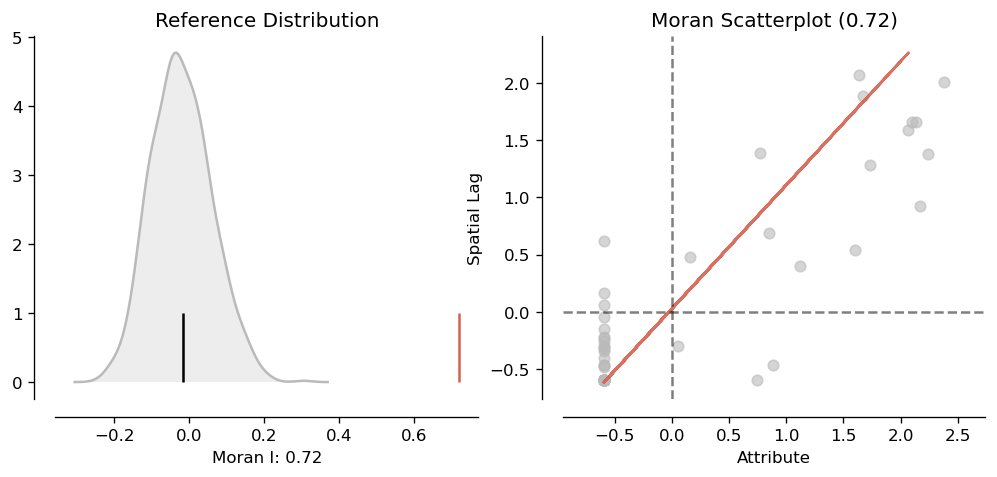

In [347]:
w_queen = Queen.from_dataframe(gc_full_agg)
mo = Moran(np.array(gc_full_agg['ic_u_min']),w_queen)
plot_moran(mo, zstandard=True, figsize=(10,4))
plt.show()

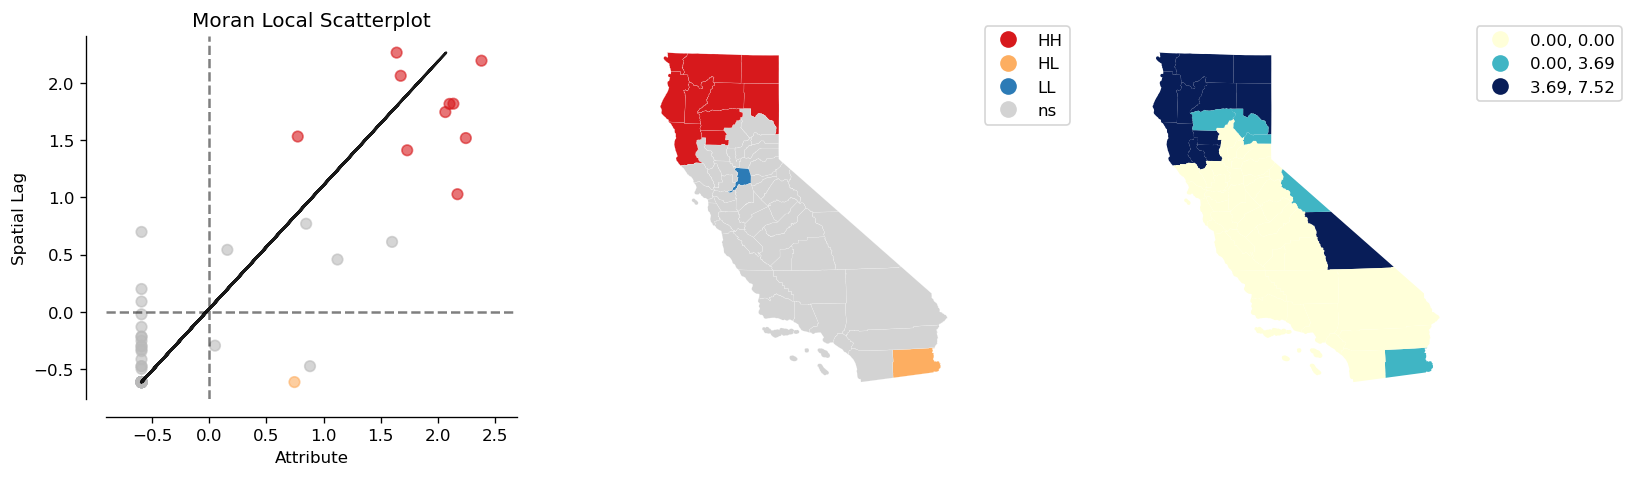

In [353]:
mol = Moran_Local(gc_full_agg['ic_u_min'].values, w_queen)
plot_local_autocorrelation(mol, gpd.GeoDataFrame(gc_full_agg), 'ic_u_min')
plt.show()

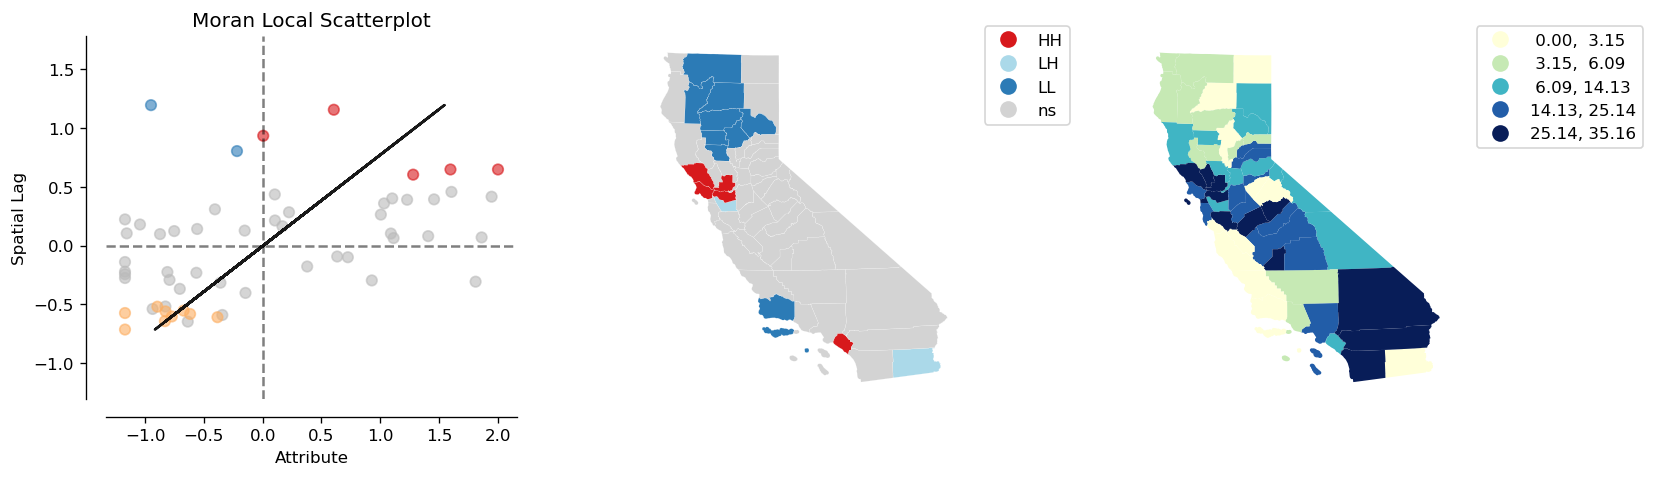

In [363]:
mol = Moran_Local(gc_dr_agg['case'].values, w_queen)
plot_local_autocorrelation(mol, gc_dr_agg, 'case')
plt.show()

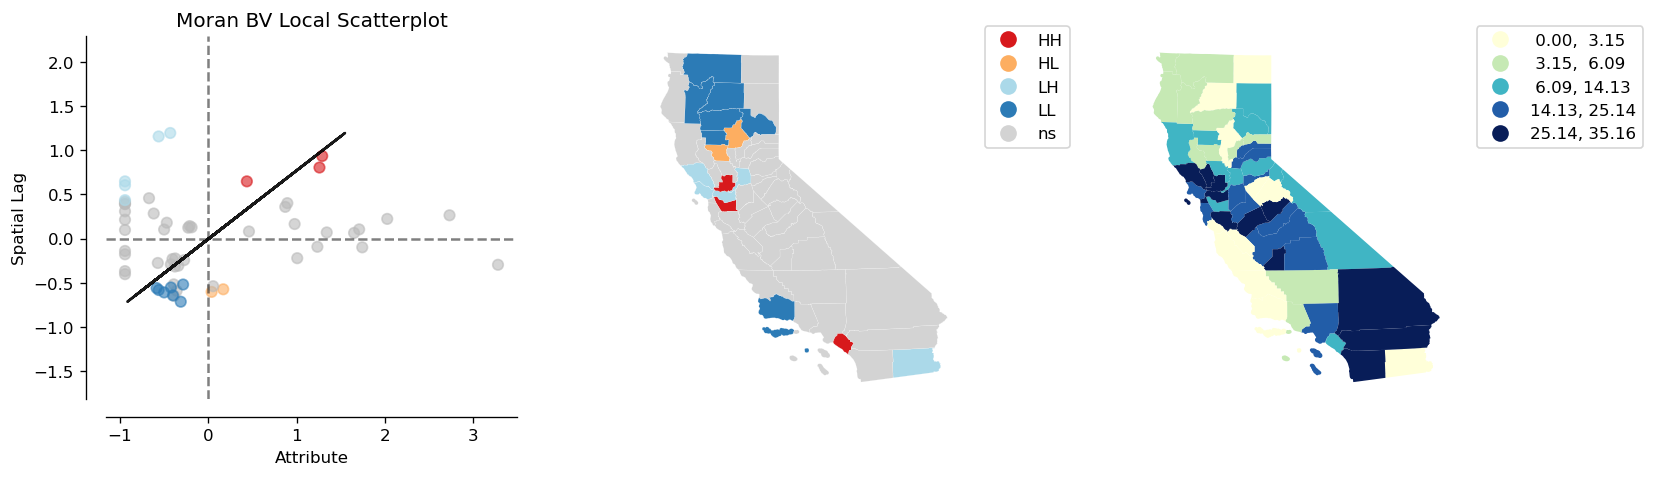

In [367]:
moran_loc_bv = Moran_Local_BV(gc_dr_agg['workplaces'].values, gc_dr_agg['case'].values, w_queen)
plot_local_autocorrelation(moran_loc_bv, gc_dr_agg, 'case')
plt.show()

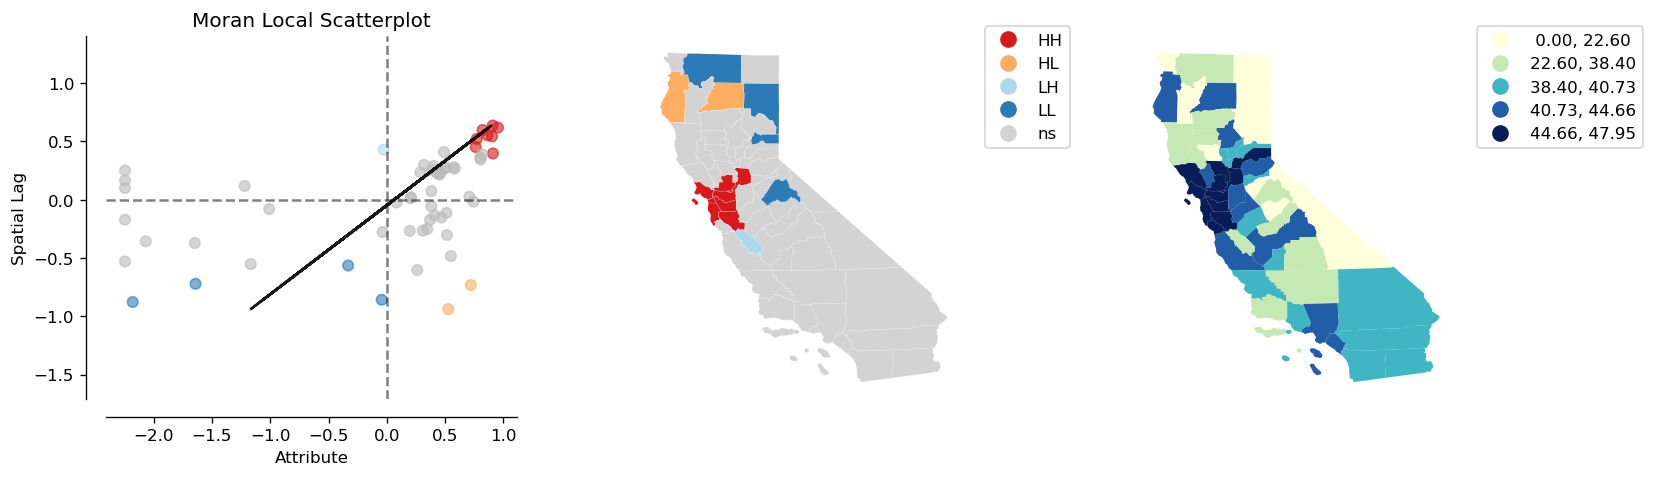

In [354]:
mol = Moran_Local(gc_full_agg['residential'].values, w_queen)
plot_local_autocorrelation(mol, gc_full_agg, 'residential')
plt.show()

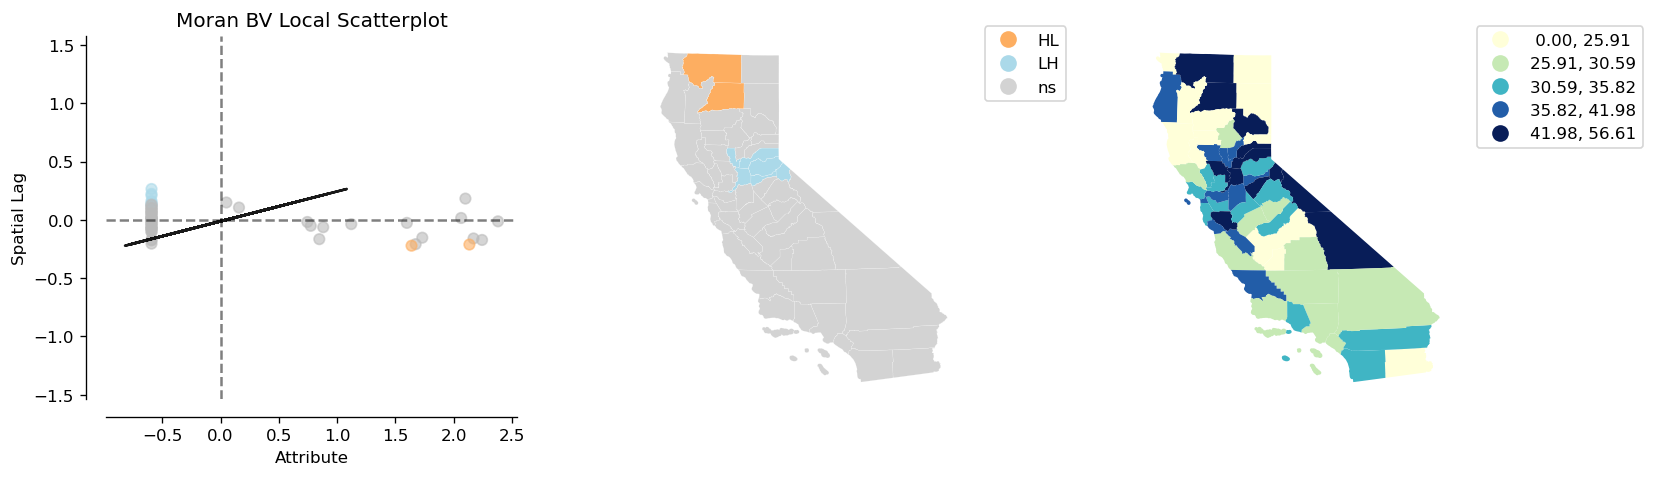

In [359]:
moran_loc_bv = Moran_Local_BV(gc_full_agg['ic_u_min'].values, gc_full_agg['case'].values, w_queen)
plot_local_autocorrelation(moran_loc_bv, gc_full_agg, 'case')
plt.show()

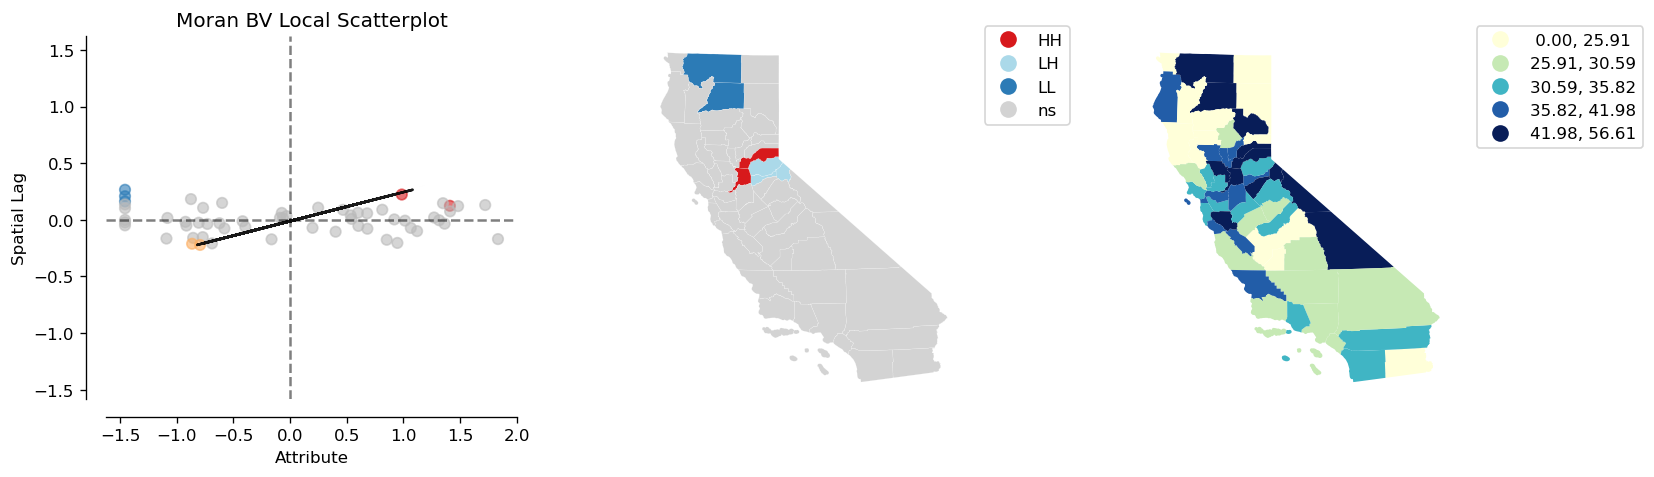

In [362]:
moran_loc_bv = Moran_Local_BV(gc_full_agg['ic_n_std'].values, gc_full_agg['case'].values, w_queen)
plot_local_autocorrelation(moran_loc_bv, gc_full_agg, 'case')
plt.show()

Generate training, validation, and testing sets

In [216]:
def train_gwr(X, y, cols):
    u = X.centroid.x    ## get centroid x
    v = X.centroid.y    ## get centroid y
    g_X = X[cols].values
    g_y = y.values
    g_coords = list(zip(u,v))
    g_X = (g_X - g_X.mean(axis=0)) / (g_X.std(axis=0)+eps)  ## independent variable normalization
    g_y = (g_y - g_y.mean(axis=0)) / (g_y.std(axis=0)+eps)  ## dependent variable normalization
    g_y = g_y.reshape((-1,1))
    
    gwr_selector = Sel_BW(g_coords, g_y, g_X,fixed=True,kernel='gaussian')
    gwr_bw = gwr_selector.search(criterion='AICc')

    gwr = GWR(g_coords, g_y, g_X, gwr_bw, fixed=True,kernel='gaussian')
    gwr_results = gwr.fit()
    scale = gwr_results.scale
    residuals = gwr_results.resid_response

    pred_results = gwr.predict(np.array(g_coords), np.array(g_X), scale, residuals)

#     np.corrcoef(pred_results.predictions.flatten(), g_y.flatten())
    mse = mean_squared_error(pred_results.predictions.flatten(), g_y.flatten())
    
    return (gwr, gwr_results), mse

In [217]:
def val_gwr(X, y, cols, model):
    eps = 1e-7
    u = X.centroid.x    ## get centroid x
    v = X.centroid.y    ## get centroid y
    g_X = X[cols].values
    g_y = y.values
    g_coords = list(zip(u,v))
    g_X = (g_X - g_X.mean(axis=0)) / (g_X.std(axis=0)+eps)  ## independent variable normalization
    g_y = (g_y - g_y.mean(axis=0)) / (g_y.std(axis=0)+eps)  ## dependent variable normalization
    g_y = g_y.reshape((-1,1))
    
    gwr, gwr_results = model[0], model[1]
    scale = gwr_results.scale
    residuals = gwr_results.resid_response

    pred_results = gwr.predict(np.array(g_coords), np.array(g_X), scale, residuals)
    mse = mean_squared_error(pred_results.predictions.flatten(), g_y.flatten())
    
    return mse

In [218]:
def cross_validation(X, y, cols, ftrain, fval):
    model, best_val = None, float('inf') # record model generating best validation loss
    
    kf = KFold(n_splits=10)
    kf.get_n_splits(X)

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
#         print(X_train.shape, X_val.shape,y_train.shape, y_val.shape)
        tmodel, tloss = ftrain(X_train, y_train, cols)
        vloss = fval(X_val, y_val, cols, tmodel)
        
        print('Train MSE:', tloss, 'Validation MSE:', vloss)
        if vloss < best_val:
            model, best_val = tmodel, vloss
    return model, best_val

In [221]:
slice_train = int(gc_dr[:-data.shape[1]].shape[0]*0.8)
X, y = gc_dr[:-data.shape[1]].reset_index(drop=True), gc_dr['case'][data.shape[1]:].reset_index(drop=True)

tmodel, vmse = cross_validation(X.iloc[:slice_train], y.iloc[:slice_train], cols_tmp, train_gwr, val_gwr)
gwr, gwr_results = tmodel
print(gwr_results.summary())

Train MSE: 0.35385581853900294 Validation MSE: 0.8766770846099154
Train MSE: 0.33831542081543475 Validation MSE: 1.1664788403617052
Train MSE: 0.35794513495030483 Validation MSE: 1.1179149377016602
Train MSE: 0.38405716287411185 Validation MSE: 0.6583460535393946
Train MSE: 0.37907220255590757 Validation MSE: 0.7191486723492314
Train MSE: 0.3857802419648775 Validation MSE: 0.7490075938696389
Train MSE: 0.3760885673209891 Validation MSE: 0.6830272441261995
Train MSE: 0.37491357629898375 Validation MSE: 0.6210301920356077
Train MSE: 0.3877924523372787 Validation MSE: 0.6802175398915796
Train MSE: 0.40310026702128177 Validation MSE: 0.5021374643932932
Model type                                                         Gaussian
Number of observations:                                                2506
Number of covariates:                                                    45

Global Regression Results
---------------------------------------------------------------------------
Residual sum

In [47]:
dump(gwr, 'models/gwr.joblib')

['models/gwr.joblib']

In [48]:
test_loss = val_gwr(X[slice_train:], y[slice_train:], cols_tmp, (gwr, gwr_results))
print('Test MSE:', test_loss)

Test MSE: 0.6727147695668322


In [389]:
# map parameter ids to column names
for i, c in enumerate(cols_tmp):
    print(i+1, c)

1 grocery_n_pharmacy
2 retail_n_recreation
3 workplaces
4 parks
5 residential
6 transit_stations
7 ic_s_mean
8 ic_n_mean
9 ic_n_50
10 ic_s_std
11 ic_n_min
12 ic_s_25
13 ic_w_50
14 ic_s_75
15 ic_n_75
16 ic_s_min
17 ic_w_std
18 ic_n_std
19 ic_w_25
20 ic_e_min
21 lc_u_50
22 lc_n_min
23 ic_w_max
24 ic_w_count
25 ic_n_max
26 ic_s_max
27 ic_w_75
28 ic_e_25
29 ic_s_50
30 ic_n_25
31 lc_s_max
32 lc_w_25
33 ic_w_mean
34 ic_u_mean
35 ic_e_count
36 lc_w_min
37 ic_e_max
38 ic_e_std
39 ic_w_min
40 lc_s_std
41 ic_e_mean
42 ic_u_max
43 ic_e_50
44 case


In [407]:
#Prepare GWR results for mapping
ind = 10
X = gc_by_day_tmp[ind].copy()
y = gc_by_day_tmp[ind+1]['case']
u = X.centroid.x    ## get centroid x
v = X.centroid.y    ## get centroid y
g_X = X[cols_tmp].values
g_y = y.values
g_coords = list(zip(u,v))
g_X = (g_X - g_X.mean(axis=0)) / (g_X.std(axis=0)+eps)  ## independent variable normalization
g_y = (g_y - g_y.mean(axis=0)) / (g_y.std(axis=0)+eps)  ## dependent variable normalization
g_y = g_y.reshape((-1,1))

gwr_selector = Sel_BW(g_coords, g_y, g_X,fixed=True,kernel='gaussian')
gwr_bw = gwr_selector.search(criterion='AICc')

gwr = GWR(g_coords, g_y, g_X, gwr_bw, fixed=True,kernel='gaussian')
gwr_results = gwr.fit()
scale = gwr_results.scale
residuals = gwr_results.resid_response

pred_results = gwr.predict(np.array(g_coords), np.array(g_X), scale, residuals)
    
#Add GWR parameters to GeoDataframe
gc_dr0['gwr_intercept'] = gwr_results.params[:,0]
gc_dr0['gwr_workplaces'] = gwr_results.params[:,3]
gc_dr0['gwr_ic_s_50'] = gwr_results.params[:,29]
gc_dr0['gwr_case'] = gwr_results.params[:,44]

#Obtain t-vals filtered based on multiple testing correction
gwr_filtered_t = gwr_results.filter_tvals()

In [401]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                  58
Number of covariates:                                                    45

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              1.976
Log-likelihood:                                                      15.703
AIC:                                                                 58.595
AICc:                                                               453.686
BIC:                                                                -50.810
R2:                                                                   0.966
Adj. R2:                                                              0.851

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

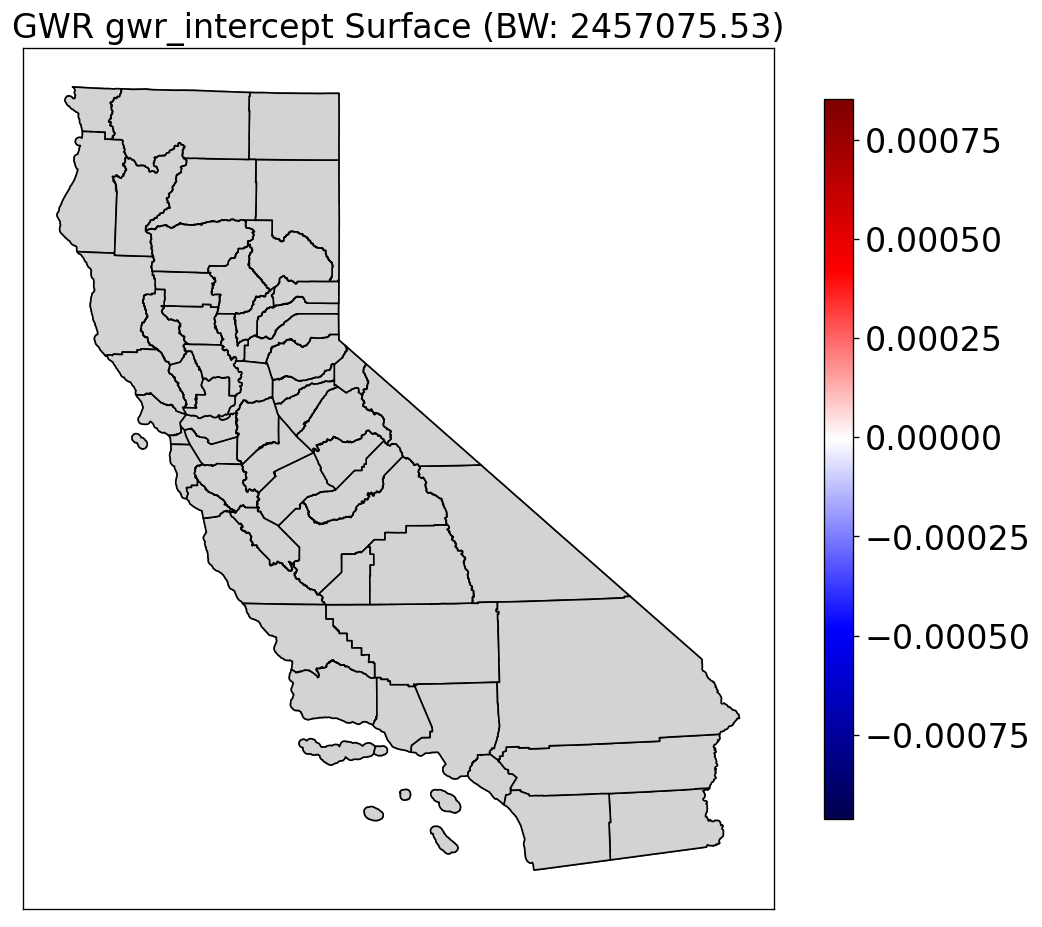

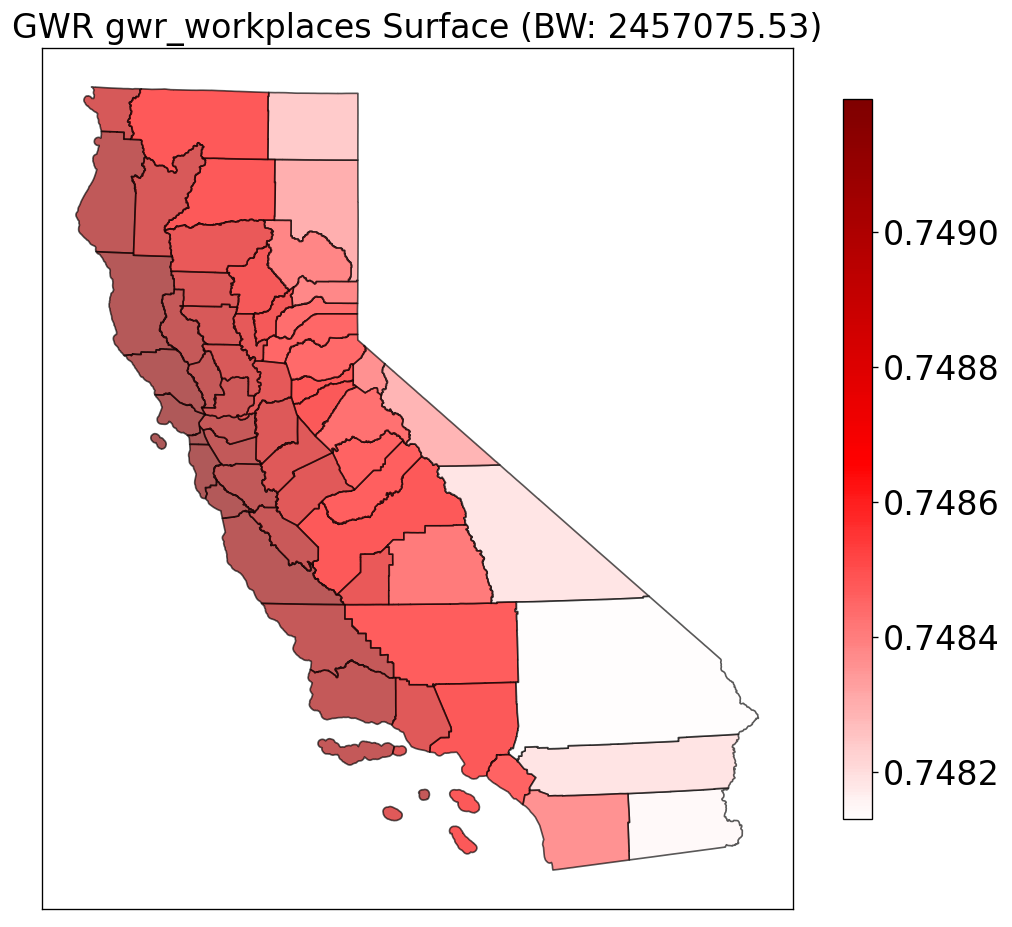

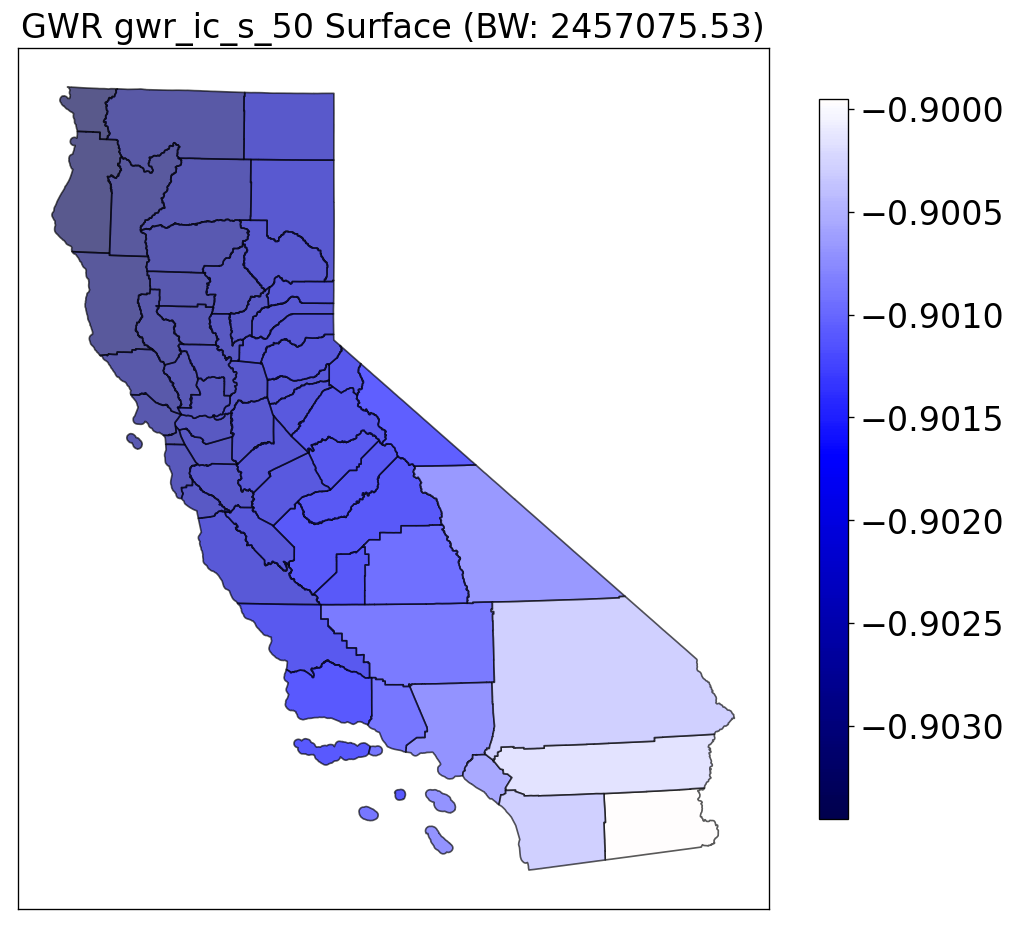

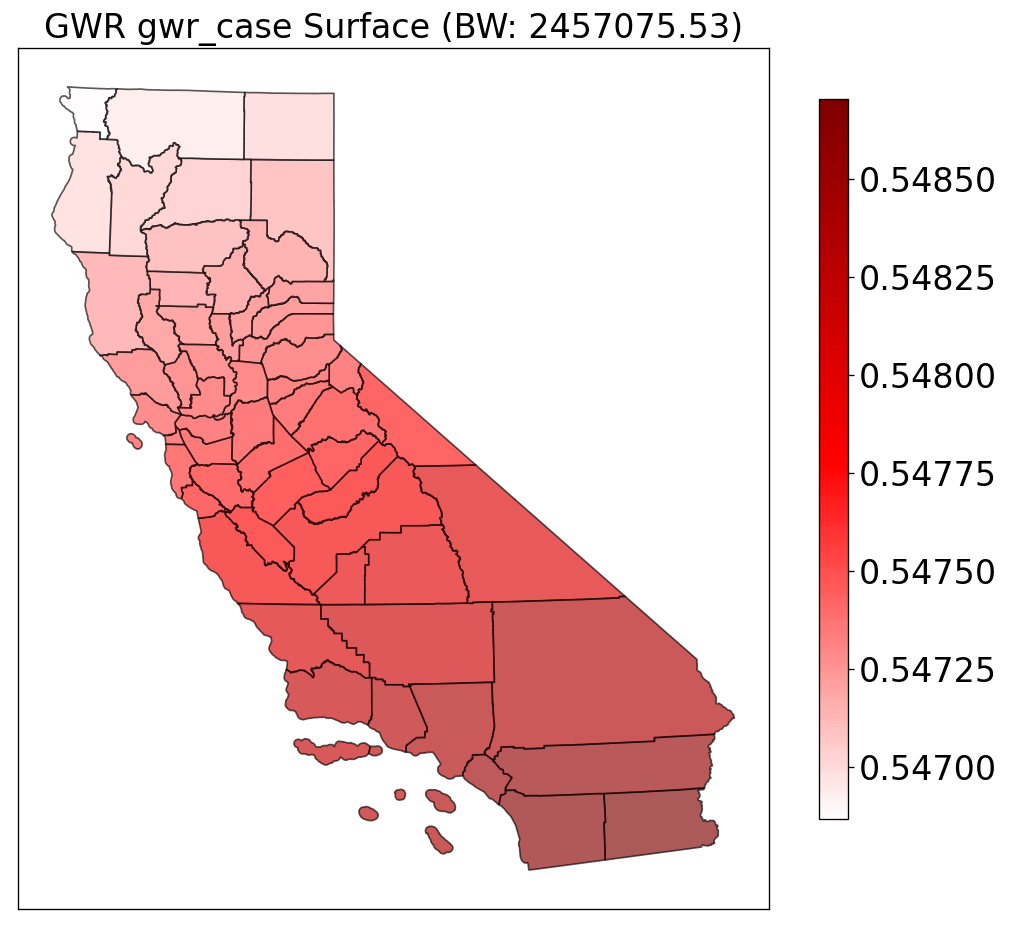

In [413]:
#Comparison maps of GWR parameter surfaces where the grey units pertain to statistically insignificant parameters
def plot_gwr(param_name, pid):
    #Prep plot and add axes
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax0 = axes
    ax0.set_title('GWR '+param_name+' Surface (BW: ' + str(gwr_bw) +')', fontsize=20)

    #Set color map
    cmap = plt.cm.seismic

    #Find min and max values of the two combined datasets
    gwr_min = gc_dr0[param_name].min()
    gwr_max = gc_dr0[param_name].max()
    vmin =gwr_min
    vmax = gwr_max

    #If all values are negative use the negative half of the colormap
    if (vmin < 0) & (vmax < 0):
        cmap = truncate_colormap(cmap, 0.0, 0.5)
    #If all values are positive use the positive half of the colormap
    elif (vmin > 0) & (vmax > 0):
        cmap = truncate_colormap(cmap, 0.5, 1.0)
    #Otherwise, there are positive and negative values so the colormap so zero is the midpoint
    else:
        cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

    #Create scalar mappable for colorbar and stretch colormap across range of data values
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

    #Plot GWR parameters
    gc_dr0.plot(param_name, cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
    #If there are insignificnt parameters plot gray polygons over them
    if (gwr_filtered_t[:,pid] == 0).any():
        gc_dr0[gwr_filtered_t[:,pid] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

    # Set figure options and plot 
    fig.tight_layout()    
    fig.subplots_adjust(right=0.9)
    cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax)
    cbar.ax.tick_params(labelsize=20) 
    ax0.get_xaxis().set_visible(False)
    ax0.get_yaxis().set_visible(False)
    plt.show()
    
plot_gwr('gwr_intercept', 0)
plot_gwr('gwr_workplaces', 3)
plot_gwr('gwr_ic_s_50', 29)
plot_gwr('gwr_case', 44)

In [49]:
X, y = gc_full[:-data.shape[1]].reset_index(drop=True), gc_full['case'][data.shape[1]:].reset_index(drop=True)

tmodel1, vmse1 = cross_validation(X.iloc[:slice_train], y.iloc[:slice_train], cols_tmp, train_gwr, val_gwr)
gwr1, gwr_results1 = tmodel
print(gwr_results1.summary())

Train MSE: 0.019447784502368694 Validation MSE: 0.06353187590687778
Train MSE: 0.020468221211549592 Validation MSE: 0.022048584906286924
Train MSE: 0.020732585824048133 Validation MSE: 0.012372283536256141
Train MSE: 0.019719738416364232 Validation MSE: 0.021144303926066366
Train MSE: 0.020666552208006048 Validation MSE: 0.008288804047508005
Train MSE: 0.02089314645203211 Validation MSE: 0.0068128879134749295
Train MSE: 0.018224877666336205 Validation MSE: 0.03794112470512181
Train MSE: 0.015744872151731478 Validation MSE: 0.06964521893348848
Train MSE: 0.019552494378009235 Validation MSE: 0.034775013947332054
Train MSE: 0.02220929148000349 Validation MSE: 0.014390325304216309
Model type                                                         Gaussian
Number of observations:                                                2506
Number of covariates:                                                    45

Global Regression Results
-----------------------------------------------------------

In [50]:
dump(gwr1, 'models/gwr_full.joblib')

['models/gwr_full.joblib']

In [45]:
slice_train = int(gc_dr[:-data.shape[1]].shape[0]*0.8)
X, y = gc_dr[:-data.shape[1]].reset_index(drop=True), gc_dr['case'][data.shape[1]:].reset_index(drop=True)

Spatial Lag Model (not work, discarded)

In [110]:
def slm(X, y, cols, splag=None):
    eps = 1e-2
    w_queen = Queen.from_dataframe(X) ### construct weight matrix with queen
    g_X = X[cols].values + eps
    g_y = y.values + eps
#     g_X = (g_X - g_X.mean(axis=0)) / (g_X.std(axis=0)+eps)  ## independent variable normalization
#     g_y = (g_y - g_y.mean(axis=0)) / (g_y.std(axis=0)+eps)  ## dependent variable normalization
    g_y = g_y.reshape((-1,1))
    
#     print(np.isnan(g_y).sum(), np.isnan(g_X).sum(), g_y.shape, g_X.shape, g_y[0][0], g_X[0][0])
    if not splag:
        splag = spreg.ML_Lag(g_y, g_X, w_queen)

    mse = mean_squared_error(splag.predy.flatten(), g_y.flatten())
#     print(splag.predy, mse)
    
    return splag, mse

In [63]:
def cross_validation1(X, y, cols, ftrain, fval):
    model, best_val = None, float('inf') # record model generating best validation loss
    
    kf = KFold(n_splits=10)
    kf.get_n_splits(X)

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
#         print(X_train.shape, X_val.shape,y_train.shape, y_val.shape)
        tmodel, tloss = ftrain(X_train, y_train, cols)
        vloss = fval(X_val, y_val, cols, tmodel)
        
        print('Train MSE:', tloss, 'Validation MSE:', vloss)
        if vloss < best_val:
            model, best_val = tmodel, vloss
    return model, best_val

In [111]:
tslm, vmse = cross_validation1(X.iloc[:slice_train], y.iloc[:slice_train], cols_tmp, slm, slm)
# print(tslm.summary())
_, test_loss = slm(X[slice_train+200:], y[slice_train+200:], cols_tmp, tslm)
print('Test MSE:', test_loss)

Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
invalid value encountered in log
invalid value encountered in less_equal
invalid value encountered in less_equal
invalid value encountered in greater
invalid value encountered in less
divide by zero encountered in log
invalid value encountered in less_equal


IndexError: invalid index to scalar variable.

# Time series analysis

In [98]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

Case study, taking Los Angeles County (id=18) as an example

In [239]:
# to determine the value of d, see if series need to be differenciated to be stable (symmetry along x-axis)
i = 18
_y = gc_dr.iloc[i::58].case.reset_index(drop=True)
result = adfuller(y.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) # p<0.05 means the series is stable

ADF Statistic: -10.009921
p-value: 0.000000


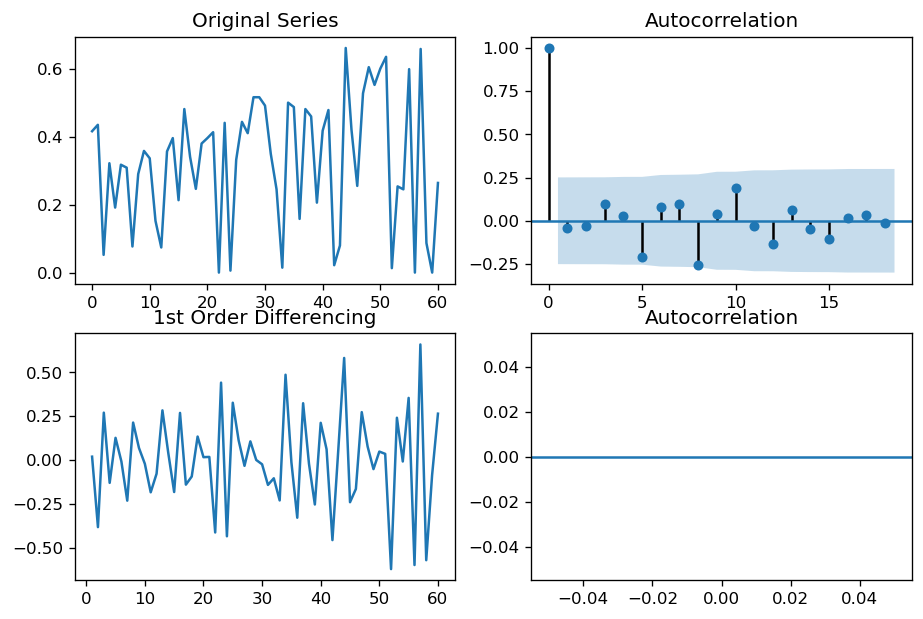

In [240]:
# take the first county as an example
plt.rcParams.update({'figure.figsize':(9,6), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(_y)
axes[0, 0].set_title('Original Series')
plot_acf(_y, ax=axes[0, 1])
# 1st Differencing
axes[1, 0].plot(_y.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(_y.diff(), ax=axes[1, 1])
plt.show()

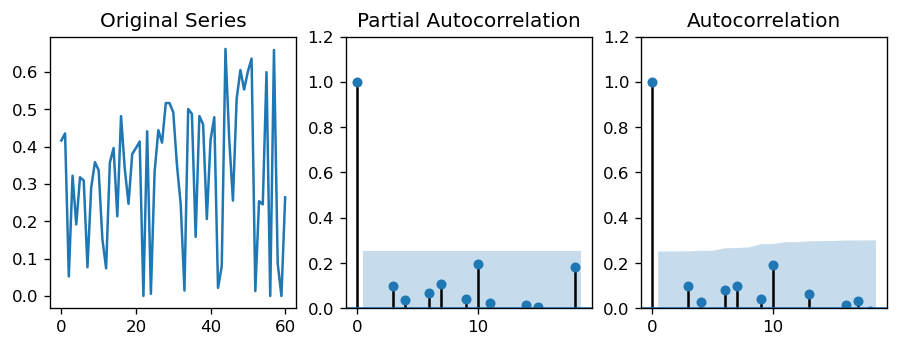

In [241]:
# to determine p, check if partial autoocorrelation > 0.05
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 3)
axes[0].plot(_y)
axes[0].set_title('Original Series')
axes[1].set(ylim=(0,1.2))
plot_pacf(_y, ax=axes[1])
axes[2].set(ylim=(0,1.2))
plot_acf(_y, ax=axes[2])
plt.show()

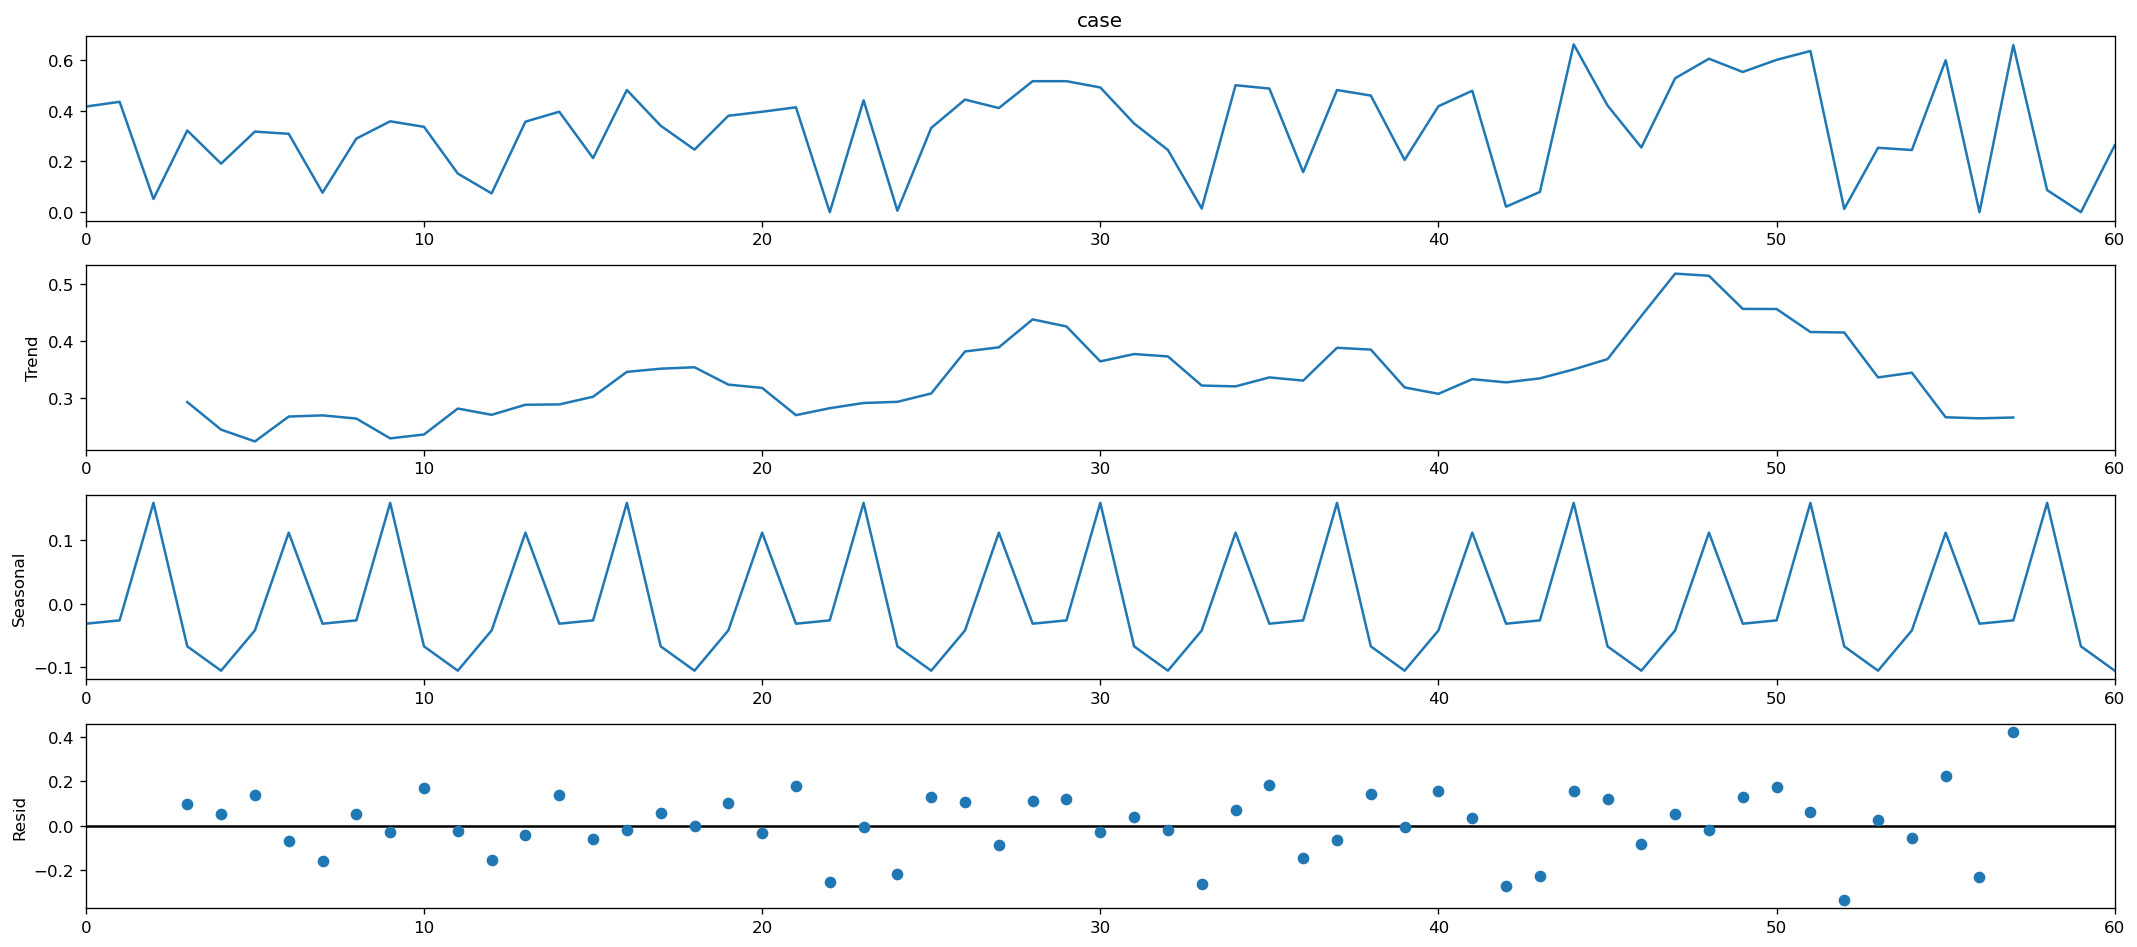

In [242]:
plt.rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(_y, model='additive', period=7)
fig = decomposition.plot()
plt.show()

In [254]:
dr_i = gc_dr.iloc[i::58].reset_index(drop=True)
slice_i = int(len(dr_i)*0.8)
Xt_train, yt_train = dr_i[cols_tmp[:-1]].iloc[:slice_t].reset_index(drop=True), dr_i['case'].iloc[:slice_t].reset_index(drop=True)
mod = sm.tsa.statespace.SARIMAX(yt_train, Xt_train, order=(0,1,1), simple_differencing=True)

In [255]:
fit_res = mod.fit(disp=False)
print(fit_res.summary())

                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  33.827
Date:                Mon, 03 May 2021   AIC                             22.347
Time:                        02:09:12   BIC                            116.592
Sample:                             0   HQIC                            59.211
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy     -0.0967      0.704     -0.137      0.891      -1.476       1.283
retail_n_recreation   -13.4423      8.227     -1.634      0.102     -29.567       2.683
workplaces      

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
invalid value encountered in true_divide
invalid value encountered in true_divide


In [256]:
Xt, yt = dr_i[cols_tmp[:-1]].reset_index(drop=True), dr_i['case'].reset_index(drop=True)
mod = sm.tsa.statespace.SARIMAX(yt, Xt, order=(0,1,1), simple_differencing=True)
res = mod.filter(fit_res.params)

In [257]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()

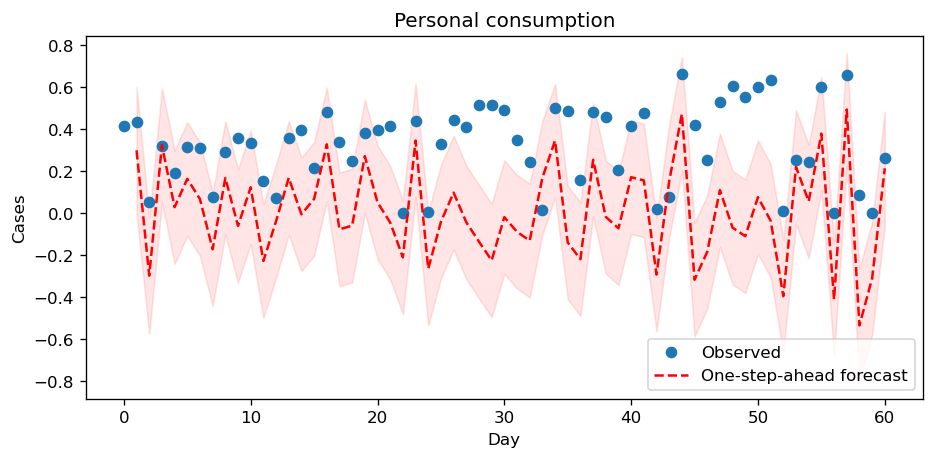

In [258]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Personal consumption', xlabel='Day', ylabel='Cases')

# Plot data points
dr_i['case'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
# predict_dy.predicted_mean.plot(ax=ax, style='g', label='Dynamic forecast (1978)')
# ci = predict_dy_ci.loc['1977-07-01':]
# ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

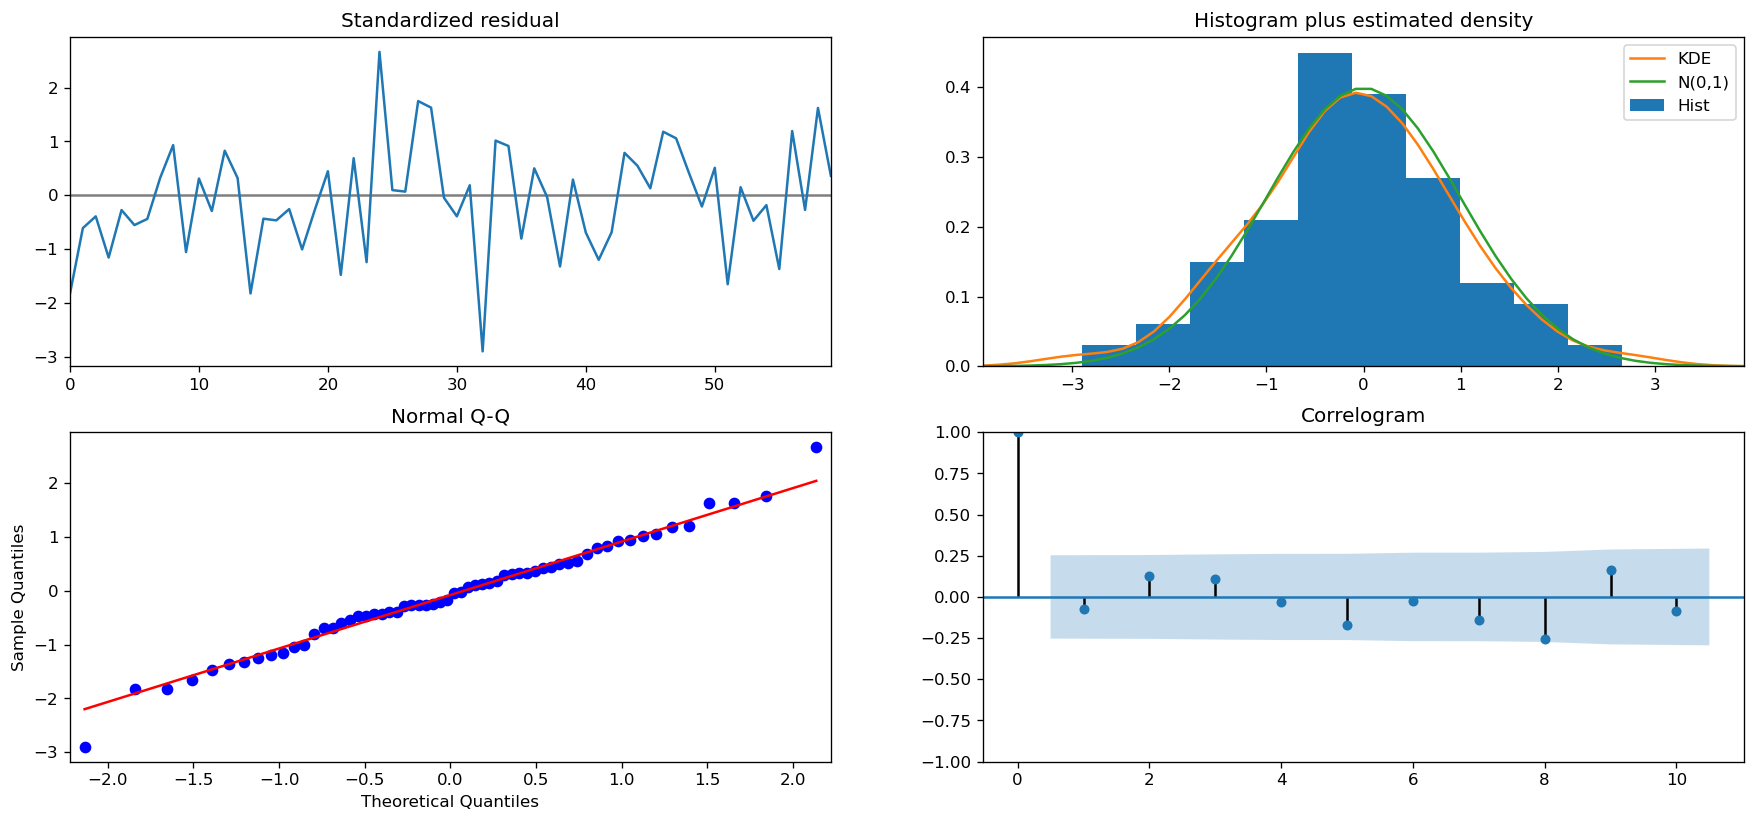

In [259]:
res.plot_diagnostics(figsize=(18, 8))
plt.show()

Generating models for each county

In [262]:
def armas_generation(gc_dr):
    armas = []
    mses = 0
    for i in range(58):
        dr_i = gc_dr.iloc[i::58].reset_index(drop=True)
        slice_i = int(len(dr_i)*0.8)
        Xt_train, yt_train = dr_i[cols_tmp[:-1]].iloc[:slice_t].reset_index(drop=True), dr_i['case'].iloc[:slice_t].reset_index(drop=True)
        mod = sm.tsa.statespace.SARIMAX(yt_train, Xt_train, order=(0,1,1), simple_differencing=True)
        fit_res = mod.fit(disp=False)
        armas.append((mod, fit_res))
        print('========================================= county {} ========================================='.format(i))
        print(fit_res.summary())

        Xt, yt = dr_i[cols_tmp[:-1]].reset_index(drop=True), dr_i['case'].reset_index(drop=True)
        mod = sm.tsa.statespace.SARIMAX(yt, Xt, order=(0,1,1), simple_differencing=True)
        res = mod.filter(fit_res.params)

        # In-sample one-step-ahead predictions
        predict = res.get_prediction()
        predict_ci = predict.conf_int()
        
        mses += mean_squared_error(dr_i['case'].iloc[1:].values.flatten(), predict.predicted_mean.values.flatten())
    return armas, mses/58
    

In [263]:
arms, mses = armas_generation(gc_dr)

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 0 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  63.255
Date:                Mon, 03 May 2021   AIC                            -36.510
Time:                        02:10:24   BIC                             57.735
Sample:                             0   HQIC                             0.354
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy  -4.233e-13         -0        inf      0.000   -4.23e-13   -4.23e-13
retail_n_re

invalid value encountered in sqrt
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide
Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 2 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  65.555
Date:                Mon, 03 May 2021   AIC                            -41.109
Time:                        02:10:25   BIC                             53.136
Sample:                             0   HQIC                            -4.245
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy   4.923e-15         -0       -inf      0.000    4.92e-15    4.92e-15
retail_n_re

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in true_divide
invalid value encountered in true_divide


========================================= county 3 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 969.965
Date:                Mon, 03 May 2021   AIC                          -1849.929
Time:                        02:10:27   BIC                          -1755.684
Sample:                             0   HQIC                         -1813.064
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy  -7.656e-09   1.16e-07     -0.066      0.947   -2.35e-07     2.2e-07
retail_n_re

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
invalid value encountered in true_divide
invalid value encountered in true_divide


========================================= county 4 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 825.122
Date:                Mon, 03 May 2021   AIC                          -1560.244
Time:                        02:10:28   BIC                          -1465.998
Sample:                             0   HQIC                         -1523.379
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy  -4.931e-09   3.21e-06     -0.002      0.999   -6.29e-06    6.28e-06
retail_n_re

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 5 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  53.008
Date:                Mon, 03 May 2021   AIC                            -16.016
Time:                        02:10:29   BIC                             78.229
Sample:                             0   HQIC                            20.848
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy     -0.5908      1.018     -0.580      0.562      -2.587       1.405
retail_n_re

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 6 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                   1.289
Date:                Mon, 03 May 2021   AIC                             87.421
Time:                        02:10:30   BIC                            181.667
Sample:                             0   HQIC                           124.286
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy   5.144e-15         -0       -inf      0.000    5.14e-15    5.14e-15
retail_n_re

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 7 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 105.407
Date:                Mon, 03 May 2021   AIC                           -120.813
Time:                        02:10:31   BIC                            -26.568
Sample:                             0   HQIC                           -83.948
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy      0.4558      0.131      3.481      0.000       0.199       0.712
retail_n_re

Maximum Likelihood optimization failed to converge. Check mle_retvals
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 8 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  51.191
Date:                Mon, 03 May 2021   AIC                            -12.382
Time:                        02:10:33   BIC                             81.864
Sample:                             0   HQIC                            24.483
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy  -1.643e-17         -0        inf      0.000   -1.64e-17   -1.64e-17
retail_n_re

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
invalid value encountered in true_divide
invalid value encountered in true_divide


========================================= county 9 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 142.986
Date:                Mon, 03 May 2021   AIC                           -195.972
Time:                        02:10:34   BIC                           -101.726
Sample:                             0   HQIC                          -159.107
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy     -0.3085      0.423     -0.729      0.466      -1.139       0.521
retail_n_re

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 10 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  74.322
Date:                Mon, 03 May 2021   AIC                            -58.644
Time:                        02:10:35   BIC                             35.601
Sample:                             0   HQIC                           -21.780
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy     -0.1527      0.209     -0.732      0.464      -0.562       0.256
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 11 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  90.836
Date:                Mon, 03 May 2021   AIC                            -91.671
Time:                        02:10:36   BIC                              2.574
Sample:                             0   HQIC                           -54.807
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy      0.3209      0.412      0.780      0.436      -0.486       1.128
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 12 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  62.440
Date:                Mon, 03 May 2021   AIC                            -34.880
Time:                        02:10:37   BIC                             59.366
Sample:                             0   HQIC                             1.985
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy     -0.9717      0.502     -1.937      0.053      -1.955       0.011
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 13 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  70.385
Date:                Mon, 03 May 2021   AIC                            -50.771
Time:                        02:10:38   BIC                             43.475
Sample:                             0   HQIC                           -13.906
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy     -1.0473      0.273     -3.833      0.000      -1.583      -0.512
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 14 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  95.798
Date:                Mon, 03 May 2021   AIC                           -101.597
Time:                        02:10:40   BIC                             -7.351
Sample:                             0   HQIC                           -64.732
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy    8.67e-19         -0       -inf      0.000    8.67e-19    8.67e-19
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt


========================================= county 15 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 128.111
Date:                Mon, 03 May 2021   AIC                           -166.221
Time:                        02:10:41   BIC                            -71.976
Sample:                             0   HQIC                          -129.356
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy     -0.0254      0.034     -0.755      0.450      -0.091       0.041
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 16 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 102.045
Date:                Mon, 03 May 2021   AIC                           -114.090
Time:                        02:10:42   BIC                            -19.845
Sample:                             0   HQIC                           -77.226
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy      0.3595      0.146      2.458      0.014       0.073       0.646
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 17 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  55.647
Date:                Mon, 03 May 2021   AIC                            -21.295
Time:                        02:10:43   BIC                             72.951
Sample:                             0   HQIC                            15.570
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy     -0.7748      0.315     -2.458      0.014      -1.393      -0.157
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
invalid value encountered in true_divide
invalid value encountered in true_divide


========================================= county 18 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  33.827
Date:                Mon, 03 May 2021   AIC                             22.347
Time:                        02:10:44   BIC                            116.592
Sample:                             0   HQIC                            59.211
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy     -0.0967      0.704     -0.137      0.891      -1.476       1.283
retail_n_r

invalid value encountered in sqrt
invalid value encountered in true_divide
invalid value encountered in true_divide
Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 20 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 119.805
Date:                Mon, 03 May 2021   AIC                           -149.611
Time:                        02:10:47   BIC                            -55.365
Sample:                             0   HQIC                          -112.746
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy     -0.0360      0.126     -0.286      0.775      -0.283       0.211
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 21 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 781.952
Date:                Mon, 03 May 2021   AIC                          -1473.905
Time:                        02:10:48   BIC                          -1379.659
Sample:                             0   HQIC                         -1437.040
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy  -6.383e-16         -0        inf      0.000   -6.38e-16   -6.38e-16
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 22 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  90.063
Date:                Mon, 03 May 2021   AIC                            -90.126
Time:                        02:10:49   BIC                              4.120
Sample:                             0   HQIC                           -53.261
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy     -0.3022      0.147     -2.063      0.039      -0.589      -0.015
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 23 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  58.778
Date:                Mon, 03 May 2021   AIC                            -27.556
Time:                        02:10:50   BIC                             66.690
Sample:                             0   HQIC                             9.309
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy   -5.22e-15         -0        inf      0.000   -5.22e-15   -5.22e-15
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 24 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  74.558
Date:                Mon, 03 May 2021   AIC                            -59.115
Time:                        02:10:51   BIC                             35.130
Sample:                             0   HQIC                           -22.251
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy      0.6266      0.187      3.354      0.001       0.260       0.993
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 25 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  44.583
Date:                Mon, 03 May 2021   AIC                              0.833
Time:                        02:10:53   BIC                             95.079
Sample:                             0   HQIC                            37.698
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy     -0.3084      0.268     -1.152      0.249      -0.833       0.216
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
invalid value encountered in true_divide
invalid value encountered in true_divide


========================================= county 26 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 782.574
Date:                Mon, 03 May 2021   AIC                          -1475.149
Time:                        02:10:54   BIC                          -1380.903
Sample:                             0   HQIC                         -1438.284
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy   -2.24e-07   1.98e-06     -0.113      0.910    -4.1e-06    3.65e-06
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 27 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 887.114
Date:                Mon, 03 May 2021   AIC                          -1684.228
Time:                        02:10:56   BIC                          -1589.983
Sample:                             0   HQIC                         -1647.363
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy    5.76e-17         -0       -inf      0.000    5.76e-17    5.76e-17
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 28 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  52.857
Date:                Mon, 03 May 2021   AIC                            -15.714
Time:                        02:10:57   BIC                             78.532
Sample:                             0   HQIC                            21.151
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy  -1.371e-14         -0        inf      0.000   -1.37e-14   -1.37e-14
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 29 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  77.011
Date:                Mon, 03 May 2021   AIC                            -64.023
Time:                        02:10:58   BIC                             30.223
Sample:                             0   HQIC                           -27.158
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy  -1.753e-14         -0        inf      0.000   -1.75e-14   -1.75e-14
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 30 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  56.825
Date:                Mon, 03 May 2021   AIC                            -23.650
Time:                        02:11:00   BIC                             70.595
Sample:                             0   HQIC                            13.214
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy  -2.865e-10         -0        inf      0.000   -2.87e-10   -2.87e-10
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 31 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  59.377
Date:                Mon, 03 May 2021   AIC                            -28.753
Time:                        02:11:01   BIC                             65.492
Sample:                             0   HQIC                             8.111
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy      0.9359      0.388      2.415      0.016       0.176       1.695
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 32 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  72.591
Date:                Mon, 03 May 2021   AIC                            -55.182
Time:                        02:11:02   BIC                             39.063
Sample:                             0   HQIC                           -18.318
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy  -9.588e-13         -0        inf      0.000   -9.59e-13   -9.59e-13
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 33 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  68.622
Date:                Mon, 03 May 2021   AIC                            -47.245
Time:                        02:11:03   BIC                             47.001
Sample:                             0   HQIC                           -10.380
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy   3.515e-14         -0       -inf      0.000    3.52e-14    3.52e-14
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt


========================================= county 34 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 270.598
Date:                Mon, 03 May 2021   AIC                           -451.196
Time:                        02:11:04   BIC                           -356.951
Sample:                             0   HQIC                          -414.332
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy      0.0034      0.009      0.389      0.697      -0.014       0.020
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 35 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  18.897
Date:                Mon, 03 May 2021   AIC                             52.205
Time:                        02:11:05   BIC                            146.451
Sample:                             0   HQIC                            89.070
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy    8.47e-15         -0       -inf      0.000    8.47e-15    8.47e-15
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
invalid value encountered in true_divide
invalid value encountered in true_divide


========================================= county 36 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  84.470
Date:                Mon, 03 May 2021   AIC                            -78.939
Time:                        02:11:07   BIC                             15.306
Sample:                             0   HQIC                           -42.075
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy     -0.4695      0.223     -2.104      0.035      -0.907      -0.032
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 37 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  95.535
Date:                Mon, 03 May 2021   AIC                           -101.071
Time:                        02:11:08   BIC                             -6.825
Sample:                             0   HQIC                           -64.206
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy  -2.055e-15         -0        inf      0.000   -2.06e-15   -2.06e-15
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
invalid value encountered in true_divide
invalid value encountered in true_divide


========================================= county 38 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  64.517
Date:                Mon, 03 May 2021   AIC                            -39.034
Time:                        02:11:09   BIC                             55.211
Sample:                             0   HQIC                            -2.170
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy     -2.3569      3.707     -0.636      0.525      -9.622       4.908
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
invalid value encountered in true_divide
invalid value encountered in true_divide


========================================= county 39 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 768.652
Date:                Mon, 03 May 2021   AIC                          -1447.305
Time:                        02:11:10   BIC                          -1353.059
Sample:                             0   HQIC                         -1410.440
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy  -8.388e-08   2.22e-06     -0.038      0.970   -4.43e-06    4.26e-06
retail_n_r

divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide
Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
invalid value encountered in true_divide
invalid value encountered in true_divide


========================================= county 41 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 769.313
Date:                Mon, 03 May 2021   AIC                          -1448.627
Time:                        02:11:14   BIC                          -1354.381
Sample:                             0   HQIC                         -1411.762
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy  -1.742e-07    1.4e-06     -0.124      0.901   -2.92e-06    2.57e-06
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 42 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 192.263
Date:                Mon, 03 May 2021   AIC                           -294.527
Time:                        02:11:15   BIC                           -200.281
Sample:                             0   HQIC                          -257.662
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy   1.546e-15         -0       -inf      0.000    1.55e-15    1.55e-15
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in true_divide
invalid value encountered in true_divide


========================================= county 43 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 850.806
Date:                Mon, 03 May 2021   AIC                          -1611.612
Time:                        02:11:17   BIC                          -1517.367
Sample:                             0   HQIC                         -1574.748
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy           0         -0        nan        nan           0           0
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 44 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  77.090
Date:                Mon, 03 May 2021   AIC                            -64.180
Time:                        02:11:18   BIC                             30.066
Sample:                             0   HQIC                           -27.315
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy      0.1423      0.321      0.443      0.658      -0.488       0.772
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 45 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  69.367
Date:                Mon, 03 May 2021   AIC                            -48.734
Time:                        02:11:20   BIC                             45.511
Sample:                             0   HQIC                           -11.869
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy     -0.3958      0.429     -0.924      0.356      -1.236       0.444
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 46 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  36.829
Date:                Mon, 03 May 2021   AIC                             16.341
Time:                        02:11:21   BIC                            110.587
Sample:                             0   HQIC                            53.206
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy      0.2998      0.359      0.836      0.403      -0.403       1.002
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 47 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  29.499
Date:                Mon, 03 May 2021   AIC                             31.002
Time:                        02:11:22   BIC                            125.248
Sample:                             0   HQIC                            67.867
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy   6.763e-15         -0       -inf      0.000    6.76e-15    6.76e-15
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 48 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 723.607
Date:                Mon, 03 May 2021   AIC                          -1357.215
Time:                        02:11:23   BIC                          -1262.969
Sample:                             0   HQIC                         -1320.350
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy   -2.38e-18         -0        inf      0.000   -2.38e-18   -2.38e-18
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 49 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 156.557
Date:                Mon, 03 May 2021   AIC                           -223.114
Time:                        02:11:24   BIC                           -128.869
Sample:                             0   HQIC                          -186.250
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy    1.47e-17         -0       -inf      0.000    1.47e-17    1.47e-17
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in true_divide
invalid value encountered in true_divide


========================================= county 50 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 777.661
Date:                Mon, 03 May 2021   AIC                          -1465.321
Time:                        02:11:27   BIC                          -1371.076
Sample:                             0   HQIC                         -1428.457
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy  -8.915e-08   3.49e-06     -0.026      0.980   -6.94e-06    6.76e-06
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 51 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  67.518
Date:                Mon, 03 May 2021   AIC                            -45.036
Time:                        02:11:28   BIC                             49.210
Sample:                             0   HQIC                            -8.171
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy      0.1025      0.393      0.261      0.794      -0.667       0.872
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 52 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  96.308
Date:                Mon, 03 May 2021   AIC                           -102.617
Time:                        02:11:29   BIC                             -8.371
Sample:                             0   HQIC                           -65.752
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy     -0.5840      0.105     -5.544      0.000      -0.790      -0.378
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 53 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 141.409
Date:                Mon, 03 May 2021   AIC                           -192.819
Time:                        02:11:31   BIC                            -98.573
Sample:                             0   HQIC                          -155.954
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy     -0.0190      0.055     -0.343      0.731      -0.128       0.090
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 54 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 226.137
Date:                Mon, 03 May 2021   AIC                           -362.273
Time:                        02:11:32   BIC                           -268.028
Sample:                             0   HQIC                          -325.409
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy  -8.407e-18         -0        inf      0.000   -8.41e-18   -8.41e-18
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals
invalid value encountered in sqrt
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


========================================= county 55 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 163.086
Date:                Mon, 03 May 2021   AIC                           -236.172
Time:                        02:11:33   BIC                           -141.926
Sample:                             0   HQIC                          -199.307
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy   5.843e-16         -0       -inf      0.000    5.84e-16    5.84e-16
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals


========================================= county 56 =========================================
                               SARIMAX Results                                
Dep. Variable:                 D.case   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 129.648
Date:                Mon, 03 May 2021   AIC                           -169.296
Time:                        02:11:34   BIC                            -75.051
Sample:                             0   HQIC                          -132.432
                                 - 60                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
grocery_n_pharmacy      0.0462      0.136      0.339      0.734      -0.221       0.313
retail_n_r

Maximum Likelihood optimization failed to converge. Check mle_retvals


In [198]:
print('Averge MSE loss:', mses)

Averge MSE loss: 0.11692741149983402


# Merging spatial and temporal model with Karlman filter

In [199]:
def updated_mean(mean1, var1, mean2, var2):
    new_mean = (mean1 * var2 + mean2 * var1) / (var1 + var2)
    return new_mean

def updated_var(var1, var2):
    new_var = 1 / ((1 / var1) + (1 / var2))
    return new_var

In [274]:
def temporal_pred(gc_dr, tmodels):
    preds = []
    for i in range(58):
        dr_i = gc_dr.iloc[i::58].reset_index(drop=True)
        slice_i = int(len(dr_i)*0.8)

        Xt, yt = dr_i[cols_tmp[:-1]].reset_index(drop=True), dr_i['case'].reset_index(drop=True)
        mod = sm.tsa.statespace.SARIMAX(yt, Xt, order=(0,1,1), simple_differencing=True)
        fit_res = tmodels[i][1]
        res = mod.filter(fit_res.params)

        # In-sample one-step-ahead predictions
        predict = res.get_prediction()
        predict_ci = predict.conf_int()
        preds.append(predict.predicted_mean.values)
    return np.array(preds).T

In [275]:
def spatial_pred(X, y, cols, model):
    eps = 1e-7
    u = X.centroid.x    ## get centroid x
    v = X.centroid.y    ## get centroid y
    g_X = X[cols].values
    g_y = y.values
    g_coords = list(zip(u,v))
    g_X = (g_X - g_X.mean(axis=0)) / (g_X.std(axis=0)+eps)  ## independent variable normalization
    g_y = (g_y - g_y.mean(axis=0)) / (g_y.std(axis=0)+eps)  ## dependent variable normalization
    g_y = g_y.reshape((-1,1))
    
    gwr_selector = Sel_BW(g_coords, g_y, g_X,fixed=True,kernel='gaussian')
    gwr_bw = gwr_selector.search(criterion='AICc')

    gwr = GWR(g_coords, g_y, g_X, gwr_bw, fixed=True,kernel='gaussian')
    gwr_results = gwr.fit()
    scale = gwr_results.scale
    residuals = gwr_results.resid_response

    pred_results = gwr.predict(np.array(g_coords), np.array(g_X), scale, residuals)
    
#     gwr, gwr_results = model[0], model[1]
    return pred_results.predictions.reshape((60, 58))
    

In [276]:
def kf_pred(df, cols, tmodels, smodels):
    # generate temporal prediction
    tpreds = temporal_pred(df, tmodels) # county*time
    
    # generate spatial prediction
    X, y = df.iloc[:-58].reset_index(drop=True), df['case'].iloc[58:].reset_index(drop=True)
#     print(X.shape, y.shape)
    spreds = spatial_pred(X, y, cols, smodels)
    print(tpreds.shape, spreds.shape)
    return tpreds, spreds  

In [277]:
tpreds, spreds = kf_pred(gc_dr, cols_tmp, arms, (gwr, gwr_results))

(60, 58) (60, 58)


In [278]:
gc_dr['case'].iloc[58:]


0     1.873714e-01
1     7.793850e-02
2     7.250139e-01
3     1.000000e-07
4     1.000000e-07
          ...     
53    2.615429e-01
54    1.000000e-07
55    1.215288e-02
56    1.771430e-01
57    7.617798e-02
Name: case, Length: 3480, dtype: float64

In [282]:
print((tpreds[0][0]*spreds[0,:].var()+spreds[0][0]*tpreds[:,0].var())/(spreds[0,:].var()+tpreds[:,0].var()+1e-7))

0.0028566383027257185


In [307]:
# combined version of the model
_Y = gc_dr['case'].iloc[58:].reset_index(drop=True)
_X = pd.DataFrame(np.stack((tpreds.flatten(), spreds.flatten())).T, columns=['t_pred', 's_pred'])
_X = sm.add_constant(_X)
model = sm.OLS(_Y,_X)
results = model.fit()
results.params

const     0.211825
t_pred    0.481916
s_pred    0.275943
dtype: float64

In [298]:
# only time series model
_X0 = pd.DataFrame(tpreds.flatten(), columns=['t_pred'])
_X0 = sm.add_constant(_X0)
model = sm.OLS(_Y,_X0)
results0 = model.fit()
results0.params

const     0.212525
t_pred    0.488160
dtype: float64

In [302]:
# only spatial model
_X1 = pd.DataFrame(spreds.flatten(), columns=['s_pred'])
_X1 = sm.add_constant(_X1)
model = sm.OLS(_Y,_X1)
results1 = model.fit()
results1.params

const     0.212370
s_pred    0.277156
dtype: float64

In [305]:
print('Time MSE:', mean_squared_error(results0.params[1]*_X0.t_pred+results0.params[0], _Y))

Time MSE: 0.05613538284110456


In [304]:
print('Space MSE:', mean_squared_error(results1.params[1]*_X1.s_pred+results1.params[0], _Y))

Space MSE: 0.02893161182912139


In [308]:
print('Combined MSE:', mean_squared_error(results.params[2]*_X.s_pred+results.params[1]*_X.t_pred+results.params[0], _Y))

Combined MSE: 0.014964805163145032
